# Learning cognitive maps as clone-structured graphs
Based on https://www.nature.com/articles/s41467-021-22559-5

Code at: http://github.com/vicariousinc/naturecomm_cscg

**Clone the repo from github, Install the necessary libraries**

In [ ]:
import sys, os
if not os.path.exists('naturecomm_cscg'):
  print("Cloning naturecomm_cscg repo from github.com/vicariousinc")
  os.system("git clone http://github.com/vicariousinc/naturecomm_cscg")

!pip install cairocffi
!pip install python-igraph==0.9.8

Cloning naturecomm_cscg repo from github.com/vicariousinc
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.1/75.1 kB 1.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.3/3.3 MB 6.4 MB/s eta 0:00:00
  Created wheel for python-igraph: filename=python_igraph-0.9.8-py3-none-any.whl size=9063 sha256=a31a1bd2c6cf87fc4a538006a2f8f760cb6958b531ec6c3c7037e0f6f22d4405
  Stored in directory: /root/.cache/pip/wheels/90/a0/98/80ea8eb9e079b4723cdb5a7c86e94506e54d1823fde8ffb775
Successfully built python-igraph


***Import the needed python modules***

In [ ]:
sys.path.append('naturecomm_cscg')
import numpy as np
from chmm_actions import CHMM, forwardE, datagen_structured_obs_room, forwardE_mp, backtraceE, backtrace, forward_mp, rargmax
import matplotlib.pyplot as plt
import igraph
from matplotlib import cm, colors
import os

custom_colors = (
    np.array(
        [
            [214, 214, 214],
            [85, 35, 157],
            [253, 252, 144],
            [114, 245, 144],
            [151, 38, 20],
            [239, 142, 192],
            [214, 134, 48],
            [140, 194, 250],
            [72, 160, 162],
        ]
    )
    / 256
)
if not os.path.exists("figures"):
    os.makedirs("figures")

In [ ]:
## A Few utility functions

def plot_graph(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True) ##normalized state transition probabilities

    g = igraph.Graph.Adjacency((A > 0).tolist())
    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]
    out = igraph.plot(
        g,
        output_file,
        layout=g.layout("kamada_kawai"),
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out, states


def get_mess_fwd(chmm, x, pseudocount=0.0, pseudocount_E=0.0):
    n_clones = chmm.n_clones
    E = np.zeros((n_clones.sum(), len(n_clones)))
    last = 0
    for c in range(len(n_clones)):
        E[last : last + n_clones[c], c] = 1
        last += n_clones[c]
    E += pseudocount_E
    norm = E.sum(1, keepdims=True)
    norm[norm == 0] = 1
    E /= norm
    T = chmm.C + pseudocount
    norm = T.sum(2, keepdims=True)
    norm[norm == 0] = 1
    T /= norm
    T = T.mean(0, keepdims=True)
    log2_lik, mess_fwd = forwardE(
        T.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, x*0 , store_messages=True
    )
    return mess_fwd, E, T


def place_field(mess_fwd, rc, clone):
    assert mess_fwd.shape[0] == rc.shape[0] and clone < mess_fwd.shape[1]
    field = np.zeros(rc.max(0) + 1)
    count = np.zeros(rc.max(0) + 1, int)
    for t in range(mess_fwd.shape[0]):
        r, c = rc[t]
        field[r, c] += mess_fwd[t, clone]
        count[r, c] += 1
    count[count == 0] = 1
    return field / count


# Quickly train a CSCG on a rectangular aliased room that has only 4 unique observations

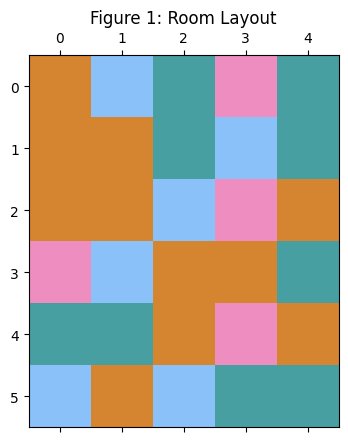

In [ ]:
room = np.array(
    [
        [1, 2, 3, 0, 3,],
        [1, 1, 3, 2, 3,],
        [1, 1, 2, 0, 1,],
        [0, 2, 1, 1, 3,],
        [3, 3, 1, 0, 1,],
        [2, 1, 2, 3, 3,],
    ]
)

# Uncomment this for generating data from a bigger room. Will take longer to train.
#
# room = np.array(
#     [
#         [1, 2, 3, 0, 3, 1, 1, 1],
#         [1, 1, 3, 2, 3, 2, 3, 1],
#         [1, 1, 2, 0, 1, 2, 1, 0],
#         [0, 2, 1, 1, 3, 0, 0, 2],
#         [3, 3, 1, 0, 1, 0, 3, 0],
#         [2, 1, 2, 3, 3, 3, 2, 0],
#     ]
# )


# Plot the layout of the room
cmap = colors.ListedColormap(custom_colors[-4:])
plt.matshow(room, cmap=cmap)
plt.title('Figure 1: Room Layout')
plt.savefig("figures/rectangular_room_layout.pdf")

In [ ]:
# Generate data from the room and train a CSCG. Takes about a minute

n_emissions = room.max() + 1
a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room

n_clones = np.ones(n_emissions, dtype=np.int64) * 80
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=42)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training   use n_iter=1000 for better training


Average number of clones: 80.0


100%|██████████| 100/100 [00:45<00:00,  2.18it/s, train_bps=0.0282]


In [ ]:
n_clones

array([80, 80, 80, 80])

In [ ]:
a, x, rc = datagen_structured_obs_room(room, length=5000)     #Use length=50000 for bigger room
np.unique(a), np.unique(x), np.unique(rc), np.unique(rc[:, [1]]), rc[0]

In [ ]:
  n_clones

array([70, 70, 70, 70])

In [ ]:
# Why do we need both em and viterbi?

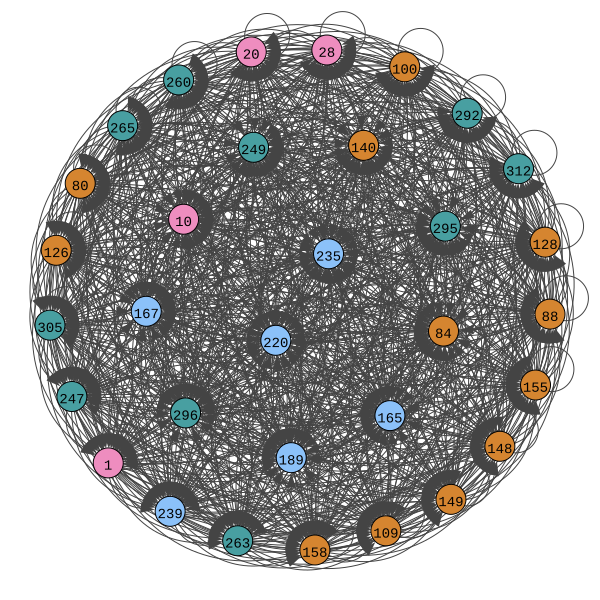

In [ ]:
# Plot graph without viterbi
graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)
graph

(array([8.027e+03, 3.800e+01, 1.900e+01, 1.700e+01, 2.900e+01, 1.800e+01,
        2.500e+01, 2.400e+01, 8.000e+00, 7.000e+00]),
 array([ 0.        ,  5.69981098, 11.39962196, 17.09943199, 22.79924393,
        28.49905396, 34.19886398, 39.89867401, 45.59848785, 51.29829788,
        56.99810791]),
 <BarContainer object of 10 artists>)

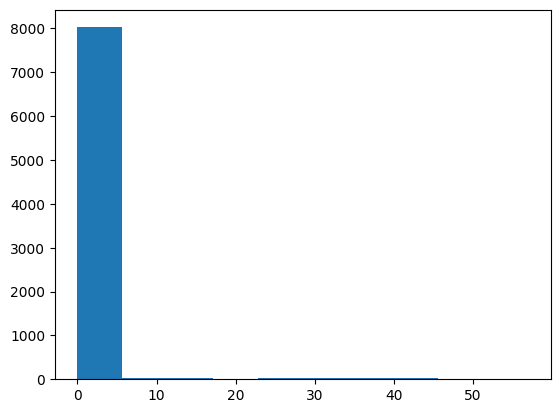

In [ ]:
plt.hist(np.unique(chmm.C))

In [ ]:
# Consolidate learning. Takes a few seconds
#chmm.pseudocount = .5
chmm.learn_viterbi_T(x, a, n_iter=100)

  3%|▎         | 3/100 [00:00<00:18,  5.14it/s, train_bps=0.025]


[0.12975864, 0.030039264, 0.025013724, 0.025013724]

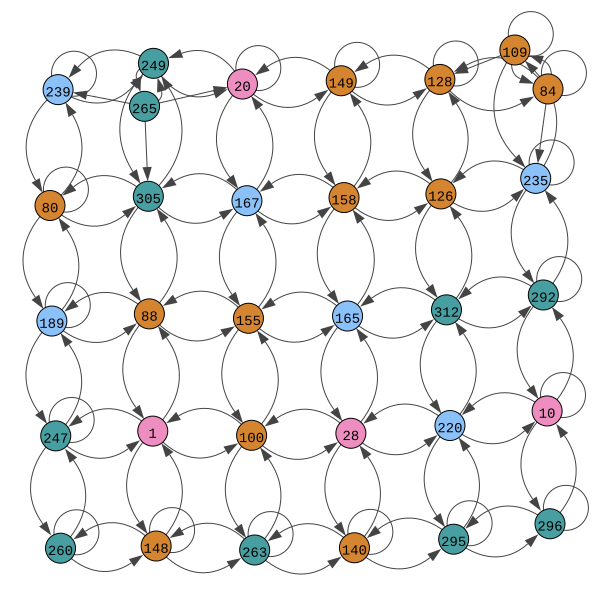

In [ ]:
# Visualize the learned, consolidated CSCG for the room.

graph, states = plot_graph(
    chmm, x, a, output_file="figures/rectangular_room_graph.pdf", cmap=cmap
)

graph
# Look for the correspondence between the graph and the original layout of the rooom in Figure 1
# Node colors correspond to the observations from the room. Node numbers are the clone/neuron numbers.

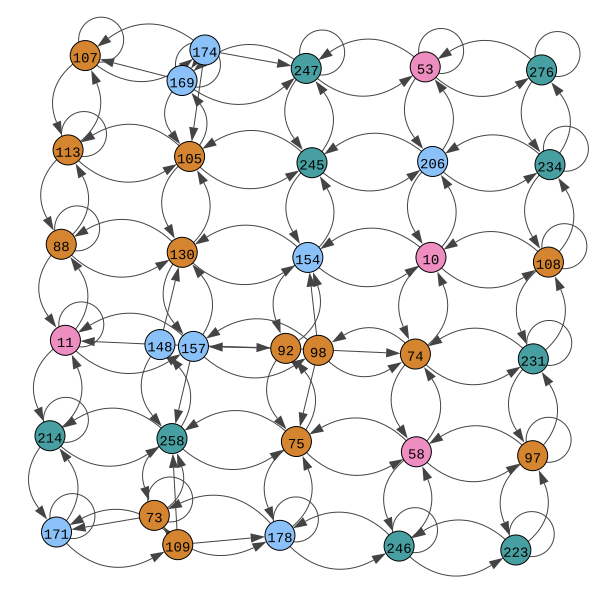

In [ ]:
import numpy as np
import igraph
from igraph import plot as igraph_plot
import matplotlib.pyplot as plt


#Mirror the graph to make it consistent with the plot of the room


def plot_graph_mirrored(
    chmm, x, a, output_file, cmap=cm.Spectral, multiple_episodes=False, vertex_size=30
):
    states = chmm.decode(x, a)[1]

    v = np.unique(states)
    if multiple_episodes:
        T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
        v = v[1:]
    else:
        T = chmm.C[:, v][:, :, v]
    A = T.sum(0)
    A /= A.sum(1, keepdims=True)  # Normalized state transition probabilities

    g = igraph.Graph.Adjacency((A > 0).tolist())

    # Compute the layout
    layout = g.layout("kamada_kawai")

    # Get the x and y coordinates
    coords = np.array(layout.coords)

    # Mirror the y-coordinates of the vertices
    coords[:, 1] = -coords[:, 1]

    # Create a new layout with the mirrored coordinates
    mirrored_layout = igraph.Layout(coords.tolist())

    node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
    if multiple_episodes:
        node_labels -= 1
    colors = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]

    out = igraph_plot(
        g,
        output_file,
        layout=mirrored_layout,
        vertex_color=colors,
        vertex_label=v,
        vertex_size=vertex_size,
        margin=50,
    )

    return out

# Usage:
graph_mirrored = plot_graph_mirrored(
    chmm, x, a, output_file="figures/rectangular_room_graph_mirrored.pdf", cmap=cmap
)

graph_mirrored




(array([86.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 88.]),
 array([3.14663375e-05, 9.91504192e-02, 1.98269382e-01, 2.97388315e-01,
        3.96507293e-01, 4.95626241e-01, 5.94745219e-01, 6.93864167e-01,
        7.92983115e-01, 8.92102063e-01, 9.91221011e-01]),
 <BarContainer object of 10 artists>)

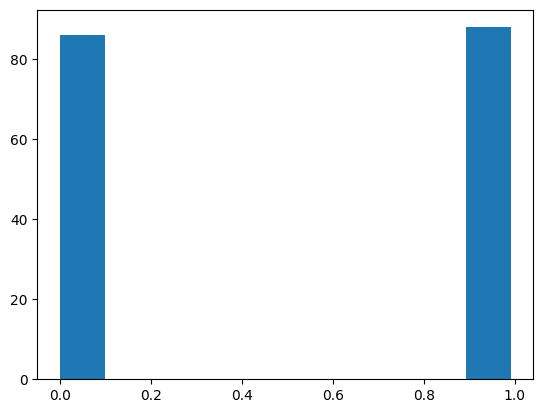

In [ ]:
plt.hist(np.unique(chmm.T))

(array([1., 3., 4., 5., 4., 6., 7., 6., 5., 2.]),
 array([ 0.        ,  6.30000019, 12.60000038, 18.89999962, 25.20000076,
        31.5       , 37.79999924, 44.09999847, 50.40000153, 56.70000076,
        63.        ]),
 <BarContainer object of 10 artists>)

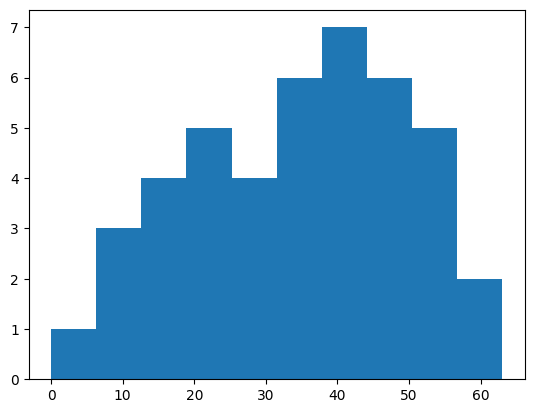

In [ ]:
plt.hist(np.unique(chmm.C))

In [ ]:
np.unique(np.where(chmm.T!=0))

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,
        26,  27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,
        39,  40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,
        52,  53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,
        65,  66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,
        78,  79,  80,  81,  82,  83,  84,  85,  86,  87,  88,  89,  90,
        91,  92,  93,  94,  95,  96,  97,  98,  99, 100, 101, 102, 103,
       104, 105, 106, 107, 108, 109, 110, 111, 112, 113, 114, 115, 116,
       117, 118, 119, 120, 121, 122, 123, 124, 125, 126, 127, 128, 129,
       130, 131, 132, 133, 134, 135, 136, 137, 138, 139, 140, 141, 142,
       143, 144, 145, 146, 147, 148, 149, 150, 151, 152, 153, 154, 155,
       156, 157, 158, 159, 160, 161, 162, 163, 164, 165, 166, 167, 168,
       169, 170, 171, 172, 173, 174, 175, 176, 177, 178, 179, 18

In [ ]:
 np.unique(np.where(chmm.C!=0))

array([  0,   1,   2,   3,  10,  11,  53,  58,  73,  74,  75,  88,  92,
        97,  98, 105, 107, 108, 109, 113, 130, 148, 154, 157, 169, 171,
       174, 178, 206, 214, 223, 231, 234, 245, 246, 247, 258, 276])

In [ ]:
chmm.C.shape

(4, 280, 280)

In [ ]:
mess_fwd, E, T = get_mess_fwd(chmm, x, pseudocount_E=0.0001)

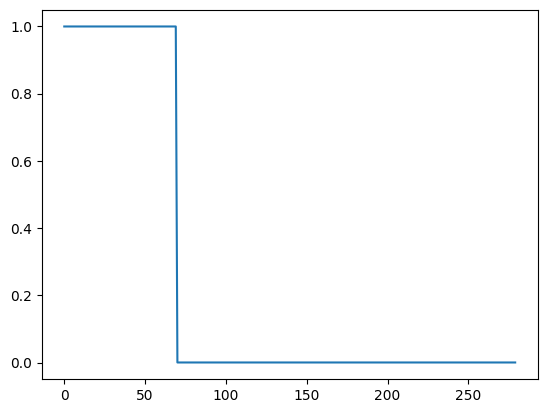

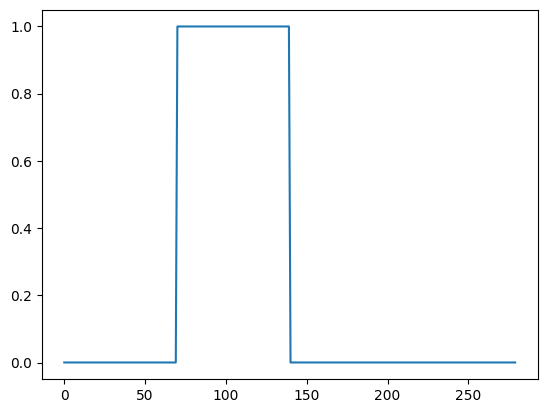

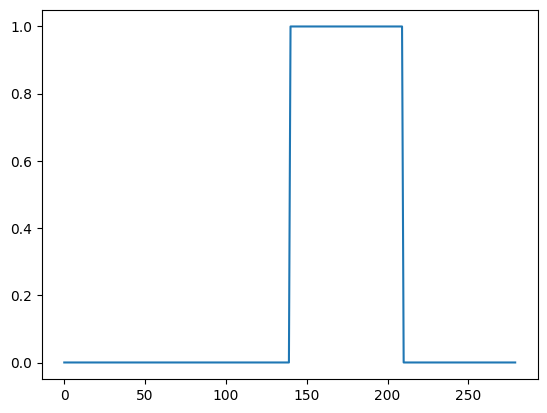

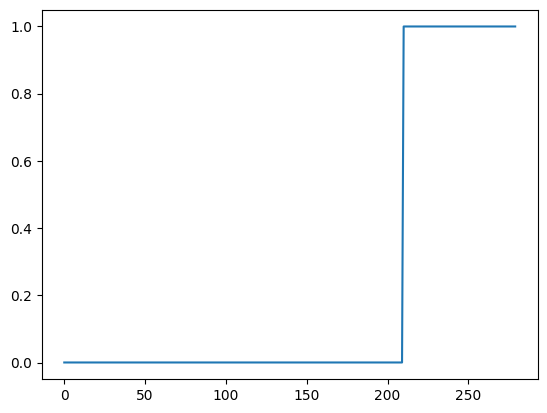

In [ ]:
for i in range(4):
  plt.figure()
  plt.plot(E[:,i])

In [ ]:
E.shape

(280, 4)

(array([1., 0., 0., 0., 0., 1., 0., 0., 0., 1.]),
 array([0.        , 0.05      , 0.1       , 0.15000001, 0.2       ,
        0.25      , 0.30000001, 0.34999999, 0.40000001, 0.44999999,
        0.5       ]),
 <BarContainer object of 10 artists>)

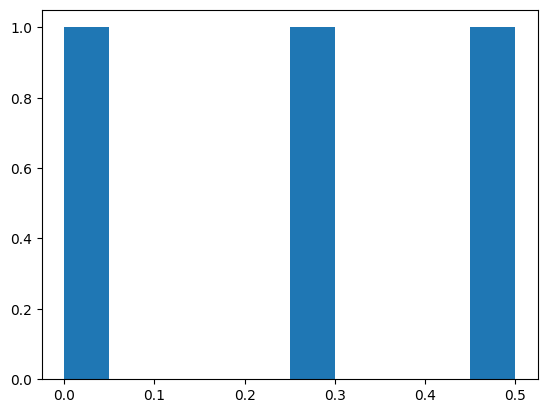

In [ ]:
plt.hist(np.unique(T))

In [ ]:
np.unique(np.where(T[0]!=0))

array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97,  98, 105, 107,
       108, 109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214,
       223, 231, 234, 245, 246, 247, 258, 276])

In [ ]:
np.unique(chmm.C)

array([ 0., 10., 11., 12., 13., 14., 15., 16., 19., 21., 22., 24., 25.,
       26., 27., 28., 31., 32., 33., 34., 35., 36., 37., 38., 39., 40.,
       41., 42., 43., 44., 45., 46., 47., 48., 49., 50., 51., 52., 53.,
       54., 56., 57., 63.], dtype=float32)

In [ ]:
states = chmm.decode(x, a)[1]
v = np.unique(states)
active_clones = v
T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
A = T.sum(0)
A /= A.sum(1, keepdims=True)
A

array([[0.33043477, 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.33653846, 0.        , ..., 0.35576922, 0.        ,
        0.30769232],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.36885247, 0.        , ..., 0.3442623 , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.32      , 0.        , ..., 0.        , 0.        ,
        0.68      ]], dtype=float32)

In [ ]:
states.shape

(5000,)

In [ ]:
np.unique(states).shape

(34,)

In [ ]:
x.shape

(5000,)

In [ ]:
mess_fwd.shape

(5000, 280)

In [ ]:
active_clones

array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97,  98, 105, 107,
       108, 109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214,
       223, 231, 234, 245, 246, 247, 258, 276])

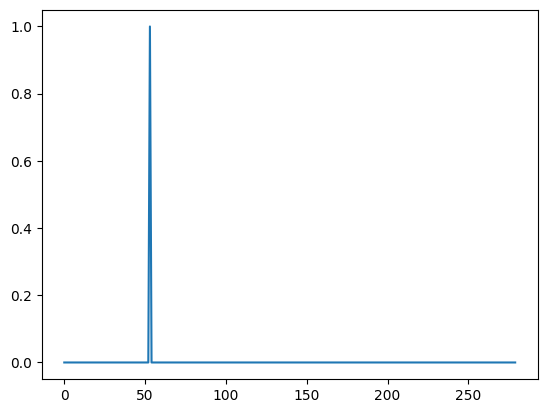

In [ ]:
plt.plot(mess_fwd[11,:])

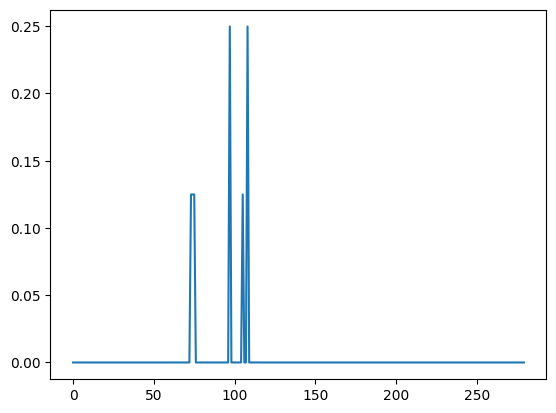

In [ ]:
plt.plot(mess_fwd[1])

In [ ]:
#check that mss_fwd always sum to 1
np.all(np.abs(np.sum(mess_fwd, axis=1))-1<.05)

True

In [ ]:
for i in range(1, 15):
  #active_clones = np.where(abs(mess_fwd[i,:]) > .01)[0]
  #print(active_clones)
  max = np.max(mess_fwd[i, :])
  clone = np.argwhere(mess_fwd[i, :] == max)
  print(f'clones {clone.flatten()}, prob: {max}' )
  if clone not in np.unique(states):
    print(f'clone: {clone} not in states')

clones [ 97 108], prob: 0.2498033046722412
clones [231], prob: 0.4164084792137146
clones [97], prob: 0.29159945249557495
clones [58], prob: 0.5383121371269226
clones [206], prob: 0.49977922439575195
clones [245], prob: 0.6662713885307312
clones [206], prob: 0.5998186469078064
clones [10], prob: 0.6248566508293152
clones [53], prob: 0.9988788962364197
clones [53], prob: 0.9986133575439453
clones [53], prob: 0.9994444251060486
clones [206], prob: 0.9993447661399841
clones [245], prob: 0.4997861385345459
clones [206], prob: 0.6664432287216187


In [ ]:
a[:15], x[:15], rc[:15]

(array([2, 2, 3, 0, 0, 2, 1, 2, 2, 2, 2, 3, 0, 3, 3]),
 array([3, 1, 3, 1, 0, 2, 3, 2, 0, 0, 0, 0, 2, 3, 2]),
 array([[3, 4],
        [2, 4],
        [1, 4],
        [2, 4],
        [2, 3],
        [2, 2],
        [1, 2],
        [1, 3],
        [0, 3],
        [0, 3],
        [0, 3],
        [0, 3],
        [1, 3],
        [1, 2],
        [2, 2]]))

In [ ]:
#from matplotlib import cm, colors

#cmap = colors.ListedColormap(custom_colors[-4:])
#node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
#colorss = [cmap(nl)[:3] for nl in node_labels / node_labels.max()]

In [ ]:
#Create the function to reconstruct the room


def reconstruct_room(message, rc, clones, node_labels):
    assert message.shape[0] == rc.shape[0]
    reconstructed_room = np.zeros((room.shape[0], room.shape[1]))
    ijs_max = []

    for i in range(len(clones)):
      clone = clones[i]
      assert clone < message.shape[1]
      field = np.zeros(rc.max(0) + 1)
      count = np.zeros(rc.max(0) + 1, int)

      for t in range(message.shape[0]):
          r, c = rc[t]
          field[r, c] += message[t, clone]
          count[r, c] += 1

      max = np.max(field)
      ij_max = np.argwhere(field == max)[0]
      ijs_max.append(ij_max)
      reconstructed_room[ij_max[0], ij_max[1]] = node_labels[i]

    return reconstructed_room, ijs_max

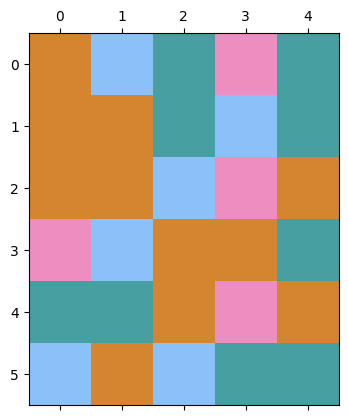

In [ ]:
# Reconstruct the room from the mess_fwd and sequence of actions and obs.
node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
reconstructed_room, ijs_max = reconstruct_room(mess_fwd, rc, v, node_labels)
plt.matshow(reconstructed_room, cmap=cmap)

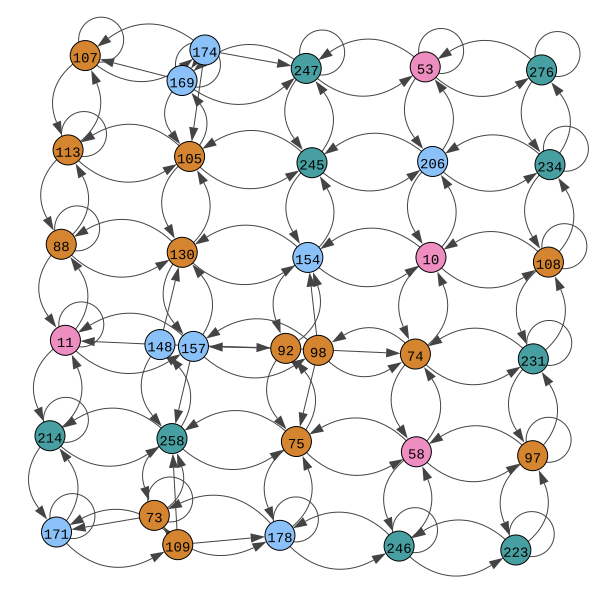

In [ ]:
graph_mirrored

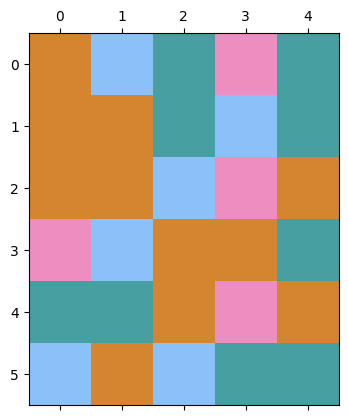

In [ ]:
plt.matshow(room, cmap=cmap)

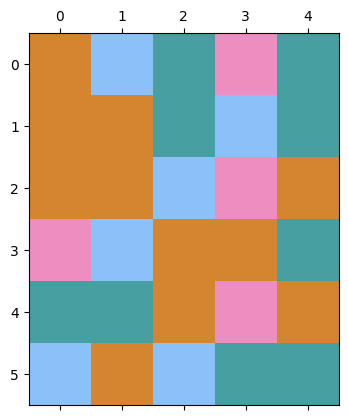

In [ ]:
plt.matshow(room, cmap=cmap)

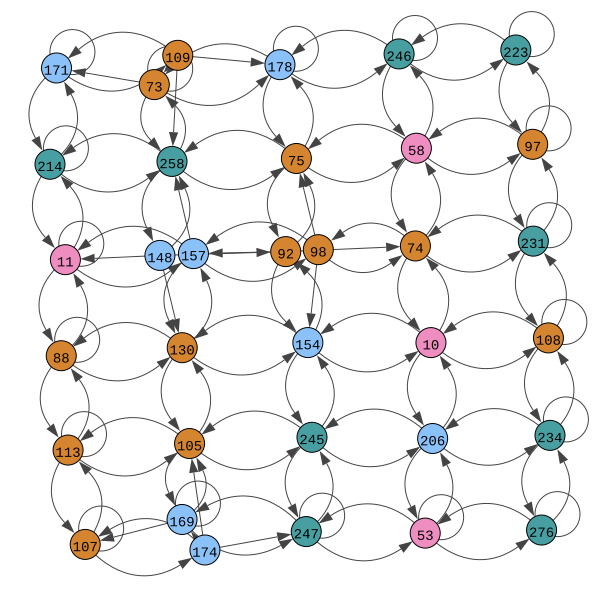

In [ ]:
graph_mirrored

In [ ]:

v

array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97,  98, 105, 107,
       108, 109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214,
       223, 231, 234, 245, 246, 247, 258, 276])

In [ ]:
#I'm trying to set mess_bwd to 0 for blocking transitions --> doesn't work

'''
mess_bwd = backwardE(chmm.T, E, n_clones, x, a)

import random
j_blocked = [10] #nodes that I block


mess_bwd[:, j_blocked] = 0
states_bwd = []

for i in range(len(x)):
  #active_clones = np.where(abs(mess_fwd[i,:]) > .01)[0]
  #print(active_clones)
  max = np.max(mess_bwd[i, :])
  clones = np.argwhere(mess_bwd[i, :] == max)
  #print(f'clones: {clones.flatten()}, prob: {max}' )
  clone = random.choice(clones)
  states_bwd.append(clone[0])
  while clone not in np.unique(states):
    print(f'clone: {clone} not in states')
    clone = random.choice(clones)
    print(clone)
'''

"\nmess_bwd = backwardE(chmm.T, E, n_clones, x, a)\n\nimport random\nj_blocked = [10] #nodes that I block\n\n\nmess_bwd[:, j_blocked] = 0\nstates_bwd = []\n\nfor i in range(len(x)):\n  #active_clones = np.where(abs(mess_fwd[i,:]) > .01)[0]\n  #print(active_clones)\n  max = np.max(mess_bwd[i, :])\n  clones = np.argwhere(mess_bwd[i, :] == max)\n  #print(f'clones: {clones.flatten()}, prob: {max}' )\n  clone = random.choice(clones)\n  states_bwd.append(clone[0])\n  while clone not in np.unique(states):\n    print(f'clone: {clone} not in states')\n    clone = random.choice(clones)\n    print(clone)\n"

In [ ]:
#check that mss_bwd always sum to 1
#np.all(np.abs(np.sum(mess_bwd, axis=1))-1<.05)

True

In [ ]:
#Plotting paths extracted

'''
start = 100
stop = 120


# Extract paths for 'states'
ijs = []
for state in states[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs.append(ij)

# Create the room plot for 'states'
room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states' path in red
x_coords, y_coords = zip(*ijs)
plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

for i in range(len(ijs) - 1):
    x_start, y_start = ijs[i]
    x_end, y_end = ijs[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

plt.title('Paths for "states"')
plt.show()

# Extract paths for 'states_bwd'
ijs_bwd = []
for state in states_bwd[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs_bwd.append(ij)

# Create the room plot for 'states_bwd'
room_plot_states_bwd = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states_bwd' path in blue
x_coords_bwd, y_coords_bwd = zip(*ijs_bwd)
plt.plot(x_coords_bwd, y_coords_bwd, color='blue', marker='o', markersize=5)

for i in range(len(ijs_bwd) - 1):
    x_start, y_start = ijs_bwd[i]
    x_end, y_end = ijs_bwd[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

for j_idx in j_blocked:
    j_node = np.argwhere(v == j_idx)[0][0]
    j_ij = (ijs_max[j_node][1], ijs_max[j_node][0])
    plt.plot(j_ij[0], j_ij[1], color='black', marker='o', markersize=15)

plt.title('Paths for "states_bwd"')
plt.show()
'''

'\nstart = 100\nstop = 120\n\n\n# Extract paths for \'states\'\nijs = []\nfor state in states[start:stop]:\n    idx_clone = np.argwhere(active_clones == state)[0][0]\n    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])\n    ijs.append(ij)\n\n# Create the room plot for \'states\'\nroom_plot_states = plt.matshow(reconstructed_room, cmap=cmap)\n\n# Plot \'states\' path in red\nx_coords, y_coords = zip(*ijs)\nplt.plot(x_coords, y_coords, color=\'red\', marker=\'o\', markersize=5)\n\nfor i in range(len(ijs) - 1):\n    x_start, y_start = ijs[i]\n    x_end, y_end = ijs[i + 1]\n    dx = x_end - x_start\n    dy = y_end - y_start\n    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc=\'red\', ec=\'red\')\n\nplt.title(\'Paths for "states"\')\nplt.show()\n\n# Extract paths for \'states_bwd\'\nijs_bwd = []\nfor state in states_bwd[start:stop]:\n    idx_clone = np.argwhere(active_clones == state)[0][0]\n    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])\n  

In [ ]:
#Checking that the two decode functions give the same result.

states = chmm.decode(x, a)[1]
statesE = chmm.decodeE(E, x, a)[1]
np.all(np.equal(states, statesE))

True

In [ ]:
#The two decode functions produce the same result; therefore, I can work on decodeE as it is easier to manipulate
#mess_fwd (different shape) to block certain transition probabilities.



In [ ]:
#Trying to set to 0 certain transitions in the message forward to block states --> doesn't work

'''
    def decodeE_changed(E, x, a, j_blocked):
        """Compute the MAP assignment of latent variables using max-product message passing
        with an alternative emission matrix."""
        log2_lik, mess_fwd = forwardE_mp(
            chmm.T.transpose(0, 2, 1),
            E,
            chmm.Pi_x,
            chmm.n_clones,
            x,
            a,
            store_messages=True,
        )

        print(mess_fwd.shape)
        mess_fwd[:, j_blocked] = 0
        states = backtraceE(chmm.T, E, chmm.n_clones, x, a, mess_fwd)
        return -log2_lik, states



j_blocked = [53]
statesE_blocked = decodeE_changed(E, x, a, j_blocked)[1]

active_clones_blocked=np.unique(statesE_blocked)
print(active_clones, active_clones_blocked)

'''

In [ ]:
#Rewriting forward and backtrace functions adding comments to analyze them



def forward_mp_prova(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)
    print("message", message)
    p_obs = message.max()
    print("p_obs", p_obs)
    assert p_obs > 0
    message /= p_obs
    print("message", message)
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        print("t_start, t_stop", t_start, t_stop)
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )
        print("aij, i, j:", aij, i, j)  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        print("(i_start, i_stop), (j_start, j_stop)", (i_start, i_stop), (j_start, j_stop))
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        print("len(new_message)", len(new_message))
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
        print("new_message", new_message)
        message = new_message
        p_obs = message.max()
        print("p_obs", p_obs)
        assert p_obs > 0
        message /= p_obs
        print("message", message)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            print("t_start, t_stop", t_start, t_stop)
            mess_fwd[t_start:t_stop] = message
            print("mess_fwd[t_start:t_stop]", mess_fwd[t_start:t_stop])
            print("\n")
    return log2_lik, mess_fwd


def rargmax_2(x, exclude=None):
    if exclude is None:
        exclude = []
    valid_indices = np.setdiff1d((x == x.max()).nonzero()[0], exclude)
    if len(valid_indices) > 0:
        return np.random.choice(valid_indices)
    return None  # Return None if no valid indices are found




def backtrace_prova(T, n_clones, x, a, mess_fwd, active_clones, default_value=0):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    print("state_loc.shape", state_loc.shape)
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    print("mess_loc.shape", mess_loc.shape)
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    print("t_start, t_stop", t_start, t_stop)
    belief = mess_fwd[t_start:t_stop]
    print("belief", belief)
    code[t] = rargmax(belief)
    print("code[t]", code[t])
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        #print("(i_start, i_stop), j_start", (i_start, i_stop), j_start)
        t_start, t_stop = mess_loc[t : t + 2]
        #print("t_start, t_stop", t_start, t_stop)
        excluded_indices = []
        while True:
            belief = mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
            current_max = rargmax_2(belief, exclude=excluded_indices)

            if current_max is None or current_max in active_clones:
                break  # Exit loop if no more max values or a valid code[t] is found

            excluded_indices.append(current_max)  # Add to excluded list for next iteration

        code[t] = current_max if current_max is not None else default_value  # Set code[t] or a default value


        #print("belief", belief)
        #print("code[t]", code[t])
    states = state_loc[x] + code
    print("state_loc[x]", state_loc[x])
    print("states"), states
    return states

In [ ]:
#Forward function with comments

'''
log2_lik_prova, mess_fwd_prova = forward_mp_prova(
            chmm.T.transpose(0, 2, 1),
            chmm.Pi_x,
            chmm.n_clones,
            x,
            a,
            store_messages=True,
        )

'''

'\nlog2_lik_prova, mess_fwd_prova = forward_mp_prova(\n            chmm.T.transpose(0, 2, 1),\n            chmm.Pi_x,\n            chmm.n_clones,\n            x,\n            a,\n            store_messages=True,\n        )\n\n'

In [ ]:
#Backtrace function with comments

'''
states_prova = backtrace_prova(chmm.T, n_clones, x, a, mess_fwd)
'''

'\nstates_prova = backtrace_prova(chmm.T, n_clones, x, a, mess_fwd)\n'

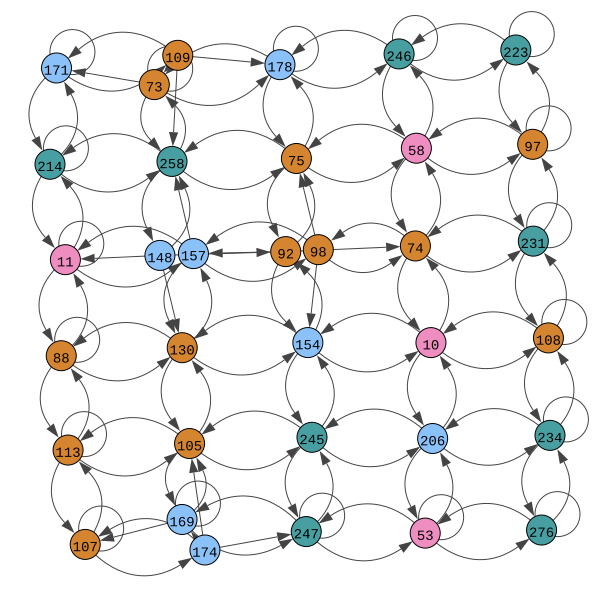

In [ ]:
graph

In [ ]:
chmm.T[:, 110, 10]

array([0.00357143, 0.00357143, 0.00357143, 0.00357143], dtype=float32)

In [ ]:
#Working on states_bwd and plotting original extracted paths vs states_bwd paths on the reconstructed room

'''
start = 340
stop = 370


# Extract paths for 'states'
print("path:", states[start:stop])
ijs = []
for state in states[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs.append(ij)

# Create the room plot for 'states'
room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states' path in red
x_coords, y_coords = zip(*ijs)
plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

for i in range(len(ijs) - 1):
    x_start, y_start = ijs[i]
    x_end, y_end = ijs[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

plt.title('Paths for "states"')
plt.show()

# Extract paths for 'states_bwd'
print("path:", statesE_blocked[start:stop])
ijs_blocked = []
for state in statesE_blocked[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs_blocked.append(ij)

# Create the room plot for 'states_bwd'
room_plot_states_blocked = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states_bwd' path in blue
x_coords_blocked, y_coords_blocked = zip(*ijs_blocked)
plt.plot(x_coords_blocked, y_coords_blocked, color='blue', marker='o', markersize=5)

for i in range(len(ijs_blocked) - 1):
    x_start, y_start = ijs_blocked[i]
    x_end, y_end = ijs_blocked[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

for j_idx in j_blocked:
    j_node = np.argwhere(v == j_idx)[0][0]
    j_ij = (ijs_max[j_node][1], ijs_max[j_node][0])
    plt.plot(j_ij[0], j_ij[1], color='black', marker='o', markersize=15)

plt.title('Paths for "states_blocked"')
plt.show()
'''

'\nstart = 340\nstop = 370\n\n\n# Extract paths for \'states\'\nprint("path:", states[start:stop])\nijs = []\nfor state in states[start:stop]:\n    idx_clone = np.argwhere(active_clones == state)[0][0]\n    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])\n    ijs.append(ij)\n\n# Create the room plot for \'states\'\nroom_plot_states = plt.matshow(reconstructed_room, cmap=cmap)\n\n# Plot \'states\' path in red\nx_coords, y_coords = zip(*ijs)\nplt.plot(x_coords, y_coords, color=\'red\', marker=\'o\', markersize=5)\n\nfor i in range(len(ijs) - 1):\n    x_start, y_start = ijs[i]\n    x_end, y_end = ijs[i + 1]\n    dx = x_end - x_start\n    dy = y_end - y_start\n    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc=\'red\', ec=\'red\')\n\nplt.title(\'Paths for "states"\')\nplt.show()\n\n# Extract paths for \'states_bwd\'\nprint("path:", statesE_blocked[start:stop])\nijs_blocked = []\nfor state in statesE_blocked[start:stop]:\n    idx_clone = np.argwhere(

In [ ]:
#Looping over the whole sequence to plot the recreated paths on the reconstructed room.

'''
for i in range(50):

  start = 100*i
  stop = 100*(i+1)


  active_clones = np.unique(states)

  # Extract paths for 'states'
  print("path:", states[start:stop])
  ijs = []
  for state in states[start:stop]:
      idx_clone = np.argwhere(active_clones == state)[0][0]
      ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
      ijs.append(ij)

  # Create the room plot for 'states'
  room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)

  # Plot 'states' path in red
  x_coords, y_coords = zip(*ijs)
  plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

  for i in range(len(ijs) - 1):
      x_start, y_start = ijs[i]
      x_end, y_end = ijs[i + 1]
      dx = x_end - x_start
      dy = y_end - y_start
      plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

  plt.title('Paths for "states"')
  plt.show()
  '''

'\nfor i in range(50):\n\n  start = 100*i\n  stop = 100*(i+1)\n\n\n  active_clones = np.unique(states)\n\n  # Extract paths for \'states\'\n  print("path:", states[start:stop])\n  ijs = []\n  for state in states[start:stop]:\n      idx_clone = np.argwhere(active_clones == state)[0][0]\n      ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])\n      ijs.append(ij)\n\n  # Create the room plot for \'states\'\n  room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)\n\n  # Plot \'states\' path in red\n  x_coords, y_coords = zip(*ijs)\n  plt.plot(x_coords, y_coords, color=\'red\', marker=\'o\', markersize=5)\n\n  for i in range(len(ijs) - 1):\n      x_start, y_start = ijs[i]\n      x_end, y_end = ijs[i + 1]\n      dx = x_end - x_start\n      dy = y_end - y_start\n      plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc=\'red\', ec=\'red\')\n\n  plt.title(\'Paths for "states"\')\n  plt.show()\n  '

In [ ]:
#Work on states_bwd function

'''
import numpy as np
import matplotlib.pyplot as plt

# Assuming you have already defined states, states_bwd, active_clones, ijs_max, and reconstructed_room
start = -15
stop = -1


# Extract paths for 'states'
ijs = []
for state in states[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs.append(ij)

# Create the room plot for 'states'
room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states' path in red
x_coords, y_coords = zip(*ijs)
plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

for i in range(len(ijs) - 1):
    x_start, y_start = ijs[i]
    x_end, y_end = ijs[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

plt.title('Paths for "states"')
plt.show()

# Extract paths for 'states_bwd'
ijs_bwd = []
for state in statesE_changed[start:stop]:
    idx_clone = np.argwhere(active_clones == state)[0][0]
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs_bwd.append(ij)

# Create the room plot for 'states_bwd'
room_plot_states_bwd = plt.matshow(reconstructed_room, cmap=cmap)

# Plot 'states_bwd' path in blue
x_coords_bwd, y_coords_bwd = zip(*ijs_bwd)
plt.plot(x_coords_bwd, y_coords_bwd, color='blue', marker='o', markersize=5)

for i in range(len(ijs_bwd) - 1):
    x_start, y_start = ijs_bwd[i]
    x_end, y_end = ijs_bwd[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

for j_idx in j_idxs:
    j_node = np.argwhere(v == j_idx)[0][0]
    j_ij = (ijs_max[j_node][1], ijs_max[j_node][0])
    plt.plot(j_ij[0], j_ij[1], color='black', marker='o', markersize=15)

plt.title('Paths for "states_bwd"')
plt.show()

'''

In [ ]:
#Plotting path on the reconstructed room.

ijs = []
for state in states[:10]:
  idx_clone = np.argwhere(active_clones==state)[0][0]
  ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
  ijs.append(ij)


room_plot = plt.matshow(reconstructed_room, cmap=cmap)

x_coords, y_coords = zip(*ijs)
plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

for i in range(len(ijs) - 1):
    x_start, y_start = ijs[i]
    x_end, y_end = ijs[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

plt.show()

Original path: [ 10  74  98  75 178]
New path: [ 10 108 231  97  58  75 178]


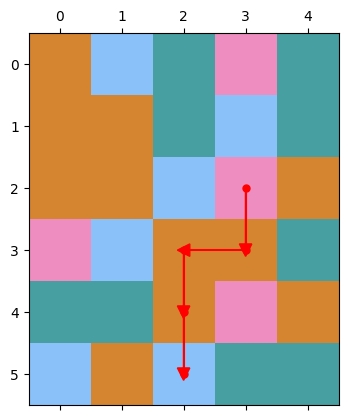

<Figure size 640x480 with 0 Axes>

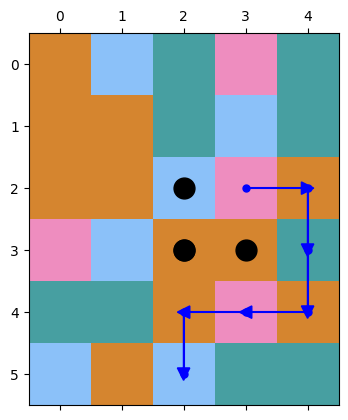

In [ ]:
#Recontruct the room and query for shortest path between two given states when blocking transitions to a specific state.


import igraph
import numpy as np
import matplotlib.cm as cm


node_labels = np.arange(x.max() + 1).repeat(n_clones)[v]
states = chmm.decode(x, a)[1]
active_clones = np.unique(states)
v = active_clones
multiple_episodes = False
if multiple_episodes:
    T = chmm.C[:, v][:, :, v][:-1, 1:, 1:]
    v = v[1:]
else:
    T = chmm.C[:, v][:, :, v]





import igraph
import numpy as np
import matplotlib.cm as cm
import matplotlib.pyplot as plt

# Your existing code here ...

# Create a directed igraph graph
g = igraph.Graph(directed=True)
g.add_vertices(len(v))
for i in range(len(v)):
    for j in range(len(v)):
        weight = T[:, i, j].sum()
        if weight > 0:
            g.add_edge(i, j, weight=weight)

# Select start and end state for the path
start_state = 10
end_state = 178

# Corresponding start/end node in the new graph (nodes are from 0 to len(v))
start_node = np.argwhere(v == start_state)[0][0]
end_node = np.argwhere(v == end_state)[0][0]

# Use Dijkstra's algorithm to find the shortest path with the original transition matrix
shortest_path_nodes_original = g.get_shortest_paths(start_node, to=end_node, weights="weight")[0]
shortest_path_states_original = active_clones[shortest_path_nodes_original]
print("Original path:", shortest_path_states_original)

ijs_original = []
for node in shortest_path_nodes_original:
    idx_clone = node
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs_original.append(ij)

# Plot the original path with the original transition matrix
room_plot = plt.matshow(reconstructed_room, cmap=cmap)
x_coords_original, y_coords_original = zip(*ijs_original)
plt.plot(x_coords_original, y_coords_original, color='red', marker='o', markersize=5)

for i in range(len(ijs_original) - 1):
    x_start, y_start = ijs_original[i]
    x_end, y_end = ijs_original[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

# Apply the changes to the transition matrix as you have already done in your code
#Change transitioin matrix to block transitions.
i_idxs = [231, 10, 58, 98, 92, 75, 130, 245, 157, 148]
j_idxs = [74, 92, 98, 154]

for i_idx in i_idxs:
  for j_idx in j_idxs:
    i = np.where(v == i_idx)[0][0]
    j = np.where(v == j_idx)[0][0]
    T[:, i, j] = 0



# Create a new directed igraph graph with the modified transition matrix
g_new = igraph.Graph(directed=True)
g_new.add_vertices(len(v))
for i in range(len(v)):
    for j in range(len(v)):
        weight = T[:, i, j].sum()
        if weight > 0:
            g_new.add_edge(i, j, weight=weight)

# Use Dijkstra's algorithm to find the shortest path with the modified transition matrix
shortest_path_nodes_new = g_new.get_shortest_paths(start_node, to=end_node, weights="weight")[0]
shortest_path_states_new = active_clones[shortest_path_nodes_new]
print("New path:", shortest_path_states_new)

ijs_new = []
for node in shortest_path_nodes_new:
    idx_clone = node
    ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
    ijs_new.append(ij)

# Plot the new path with the modified transition matrix
plt.figure()
room_plot_new = plt.matshow(reconstructed_room, cmap=cmap)
x_coords_new, y_coords_new = zip(*ijs_new)
plt.plot(x_coords_new, y_coords_new, color='blue', marker='o', markersize=5)


for j_idx in j_idxs:
    j_node = np.argwhere(v == j_idx)[0][0]
    j_ij = (ijs_max[j_node][1], ijs_max[j_node][0])
    plt.plot(j_ij[0], j_ij[1], color='black', marker='o', markersize=15)


for i in range(len(ijs_new) - 1):
    x_start, y_start = ijs_new[i]
    x_end, y_end = ijs_new[i + 1]
    dx = x_end - x_start
    dy = y_end - y_start
    plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

plt.show()


In [ ]:
graph_mirrored = plot_graph_mirrored(
    chmm, x, a, output_file="figures/rectangular_room_graph_mirrored.pdf", cmap=cmap
)

graph_mirrored

In [ ]:
np.argwhere(v==178)[0][0]

In [ ]:
shortest_path_states

In [ ]:
v

In [ ]:
#Here, I try to extract the sequence when blocking transitions to a spacific state and increasing the Emission matrix pseudocount
#on states adjacent to that state. However, the model finds new states that are not used to create the graph.


pseudocount_E = .002
pseudocount = 0
T_blocked = chmm.T.copy()


#Change transitioin matrix to block transitions.
i_adjs = []
j_blocked = [10]
for j in j_blocked:
  i_adj = np.where(T_blocked[:, :, j]>.02)[1]
  print("i_adj", i_adj)
  i_adjs.append(i_adj)
  T_blocked[:, :, j] = 0
  T_blocked[:, j, :] = 0


'''
#Change transitioin matrix to block transitions.
j_blocked = [10]
for j in j_blocked:
  idxs_in = np.where(T_blocked[:, :, j]!=0)
  idxs_out = np.where(T_blocked[:, j, :]!=0)
  print("idxs_in, idxs_out", idxs_in, idxs_out)
  a_in, i_in = idxs_in[0], idxs_in[1]
  a_out, i_out = idxs_out[0], idxs_out[1]
  assert len(a_in) == len(i_in)
  for i in range(len(a_in)):
    T_blocked[a_in[i], i_in[i], j] = 0
    i_adj = np.where(T_blocked[:, i_in[i], :]!=0)[1]
    print("i_adj", i_adj)
    #for node in i_adj:
      #T_blocked[a_in[i], i_in[i], node] = pseudocount # add small probabilities to adjacent states in actions where probs. were blocked.

    #print(T_blocked[a_in[i], i_in[i], j])
    #print(T_blocked[a_in[i], j, i_out[i]])
#T_blocked[:, :, j] = pseudocount
#T_blocked[:, i_blocked, :] = pseudocount

'''



# Block transitions to state j
#j_blocked = [10]
#for j in j_blocked:
    #T_blocked[:, :, j] = 0  # Block all transitions to state j
    #T_blocked[:, j, :] = 0  # Block all transitions from state j

# Normalize the transition matrix
norm = T_blocked.sum(2, keepdims=True)
norm[norm == 0] = 1
T_blocked /= norm


n_clones = chmm.n_clones
E = np.zeros((n_clones.sum(), len(n_clones)))
last = 0
for c in range(len(n_clones)):
    E[last : last + n_clones[c], c] = 1
    last += n_clones[c]
for i_adj in i_adjs:
  for node in i_adj:
    E[node, :] += pseudocount_E
norm = E.sum(1, keepdims=True)
norm[norm == 0] = 1
E /= norm

#T = T.mean(0, keepdims=True)
log2_lik, mess_fwdE_blocked = forwardE(
    T_blocked.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, a, store_messages=True
)


statesE_blocked = backtraceE(T_blocked, E, n_clones, x, a, mess_fwdE_blocked)

i_adj [108 154  74 206]


In [ ]:
E.shape

(280, 4)

In [ ]:
np.unique(statesE_blocked), np.unique(states)

(array([  1,   2,   4,   5,   6,   7,   8,  11,  12,  13,  14,  15,  16,
         17,  18,  19,  20,  23,  24,  25,  27,  28,  29,  30,  31,  32,
         33,  34,  35,  36,  39,  40,  41,  42,  43,  44,  45,  46,  47,
         48,  50,  51,  52,  53,  54,  55,  56,  57,  58,  59,  60,  61,
         62,  63,  65,  66,  67,  68,  69,  73,  74,  75,  83,  88,  92,
         97,  98, 103, 105, 107, 108, 109, 113, 121, 128, 129, 130, 131,
        132, 140, 142, 144, 146, 147, 148, 153, 154, 155, 157, 158, 160,
        162, 164, 166, 167, 169, 171, 172, 174, 175, 176, 177, 178, 179,
        181, 188, 199, 206, 207, 214, 223, 231, 234, 245, 246, 247, 258,
        276]),
 array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97,  98, 105, 107,
        108, 109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214,
        223, 231, 234, 245, 246, 247, 258, 276]))

In [ ]:
statesE_blocked[-20:], states[-20:]

(array([214, 258,  73, 171, 214,  11,  88,  11,  11,  88, 130,  88, 113,
        113, 105, 169, 247, 245, 247, 247]),
 array([ 74, 231,  97, 231, 108, 234, 276, 234, 206,  53, 276,  53,  53,
        247,  53,  53, 276, 234, 276, 276]))

In [ ]:
np.sum(states==10), np.sum(statesE_blocked==10)

(172, 0)

In [ ]:
#Here, I try to extract the sequence when blocking transitions to a spacific state and increasing the Emission matrix pseudocount
#on states adjacent to that state. However, the model finds new states that are not used to create the graph.


pseudocount_E = .002
pseudocount = 0
T_blocked = chmm.T.copy()


#Change transitioin matrix to block transitions.
i_adjs = []
j_blocked = [10]
for j in j_blocked:
  i_adj = np.where(T_blocked[:, :, j]>.02)[1]
  print("i_adj", i_adj)
  i_adjs.append(i_adj)
  T_blocked[:, :, j] = 0
  T_blocked[:, j, :] = 0


# Normalize the transition matrix
norm = T_blocked.sum(2, keepdims=True)
norm[norm == 0] = 1
T_blocked /= norm


n_clones = chmm.n_clones
E = np.zeros((n_clones.sum(), len(n_clones)))
last = 0
for c in range(len(n_clones)):
    E[last : last + n_clones[c], c] = 1
    last += n_clones[c]
#for i_adj in i_adjs:
  #for node in i_adj:
    #E[node, :] += pseudocount_E
norm = E.sum(1, keepdims=True)
norm[norm == 0] = 1
E /= norm

#T = T.mean(0, keepdims=True)
log2_lik, mess_fwdE_blocked = forwardE(
    T_blocked.transpose(0, 2, 1), E, chmm.Pi_x, chmm.n_clones, x, a, store_messages=True
)


statesE_blocked = backtraceE(T_blocked, E, n_clones, x, a, mess_fwdE_blocked)

i_adj [108 154  74 206]


In [ ]:
#As an alternative solution to overcome the problem encountererd, I Restrict Pi, T, and E matrices to active clones only.

num_active_clones = len(active_clones)

Pi_x_restricted = chmm.Pi_x[:num_active_clones]

T=chmm.T.copy()
T_restricted = np.zeros((T.shape[0], num_active_clones, num_active_clones))

for i in range(num_active_clones):
    for j in range(num_active_clones):
        original_i = active_clones[i]
        original_j = active_clones[j]
        T_restricted[:, i, j] = T[:, original_i, original_j]

clone_correspondence = {}
for i in range(num_active_clones):
    original_i = active_clones[i]
    clone_correspondence[i] = original_i


num_active_clones = len(active_clones)
E_restricted = np.zeros((num_active_clones, E.shape[1]))

for i in range(num_active_clones):
    original_i = clone_correspondence[i]
    E_restricted[i, :] = E[original_i, :]





In [ ]:
#T_restricted[T_restricted < 1e-2] = 0

In [ ]:
chmm.T[:, 154, 58]

array([3.8789767e-05, 3.6656900e-05, 5.4704607e-05, 4.6992496e-05],
      dtype=float32)

In [ ]:
T_restricted_blocked[0][3]

array([0.00000000e+00, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 9.98478581e-01, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05, 4.75443383e-05, 4.75443383e-05,
       4.75443383e-05, 4.75443383e-05])

In [ ]:
#Doing checks below that the restriction is correct.

In [ ]:
E_restricted.shape

(34, 4)

In [ ]:
clone_correspondence[0], clone_correspondence[13], clone_correspondence[24], clone_correspondence[5],

(10, 108, 206, 74)

In [ ]:
T_restricted_blocked[:, 0, 13]

array([4.07614246e-05, 9.98547633e-01, 4.75443380e-05, 5.39578092e-05])

In [ ]:
active_clones

array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97,  98, 105, 107,
       108, 109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214,
       223, 231, 234, 245, 246, 247, 258, 276])

In [ ]:
E_restricted[2, :], E_restricted[4, :], E[53, :], E[73, :], E_restricted[33]

(array([9.9970012e-01, 9.9960016e-05, 9.9960016e-05, 9.9960016e-05]),
 array([9.9960016e-05, 9.9970012e-01, 9.9960016e-05, 9.9960016e-05]),
 array([9.9970012e-01, 9.9960016e-05, 9.9960016e-05, 9.9960016e-05]),
 array([9.9960016e-05, 9.9970012e-01, 9.9960016e-05, 9.9960016e-05]),
 array([9.9960016e-05, 9.9960016e-05, 9.9960016e-05, 9.9970012e-01]))

In [ ]:
t_list = list(range(445, 455))


def forwardE(T_tr, E, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    #assert (n_clones.sum(), len(n_clones)) == E.shape
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    message = Pi * E[:, j]
    p_obs = message.sum()
    assert p_obs > 0
    message /= p_obs
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_fwd = np.empty((len(x), E.shape[0]), dtype=dtype)
        mess_fwd[t] = message
    for t in range(1, x.shape[0]):
        aij, j = (
            a[t - 1],
            x[t],
        )  # at time t-1 -> t we go from observation i to observation j
        message = T_tr[aij].dot(message)
        if t in t_list:
          print("t:", t, "state", rargmax(message))
        message *= E[:, j]
        if t in t_list:
          print("t:", t, "state", rargmax(message))
        p_obs = message.sum()
        assert p_obs > 0
        message /= p_obs
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            mess_fwd[t] = message
    if store_messages:
        return log2_lik, mess_fwd
    else:
        return log2_lik


def backtraceE(T, E, n_clones, x, a, mess_fwd):
    """Compute backward messages."""
    #assert (n_clones.sum(), len(n_clones)) == E.shape
    states = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    belief = mess_fwd[t]
    states[t] = rargmax(belief)
    for t in range(x.shape[0] - 2, -1, -1):
        aij = a[t]  # at time t -> t+1 we go from observation i to observation j
        belief = mess_fwd[t] * T[aij, :, states[t + 1]]
        states[t] = rargmax(belief)
        #if rargmax(mess_fwd[t]) != states[t]:
          #print(f"state on mess_fwd was {rargmax(mess_fwd[t])} but after multiplying by T matrix is {states[t]}")
        if t in t_list:
          print(f"t: {t}, state on mess_fwd was {rargmax(mess_fwd[t])} but after multiplying by T matrix is {states[t]}")
    return states



In [ ]:
np.where(np.abs(E[1, :]-1) < 0.1)

(array([0]),)

In [ ]:
n_clones()

(34, 4)

In [ ]:
#Here, I try to extract the sequence when blocking transitions to a spacific state and increasing the Emission matrix and Transition
#matrix pseucount accordingly. Specifically, I:
# - Increase the probability of transitioning from a state adjacent to the blocked state to a state adjacent to this state for the action corresponding
#to the transition from the first adjacent state to the blocked state, which was previously set to 0.
# T[action, state_adj_to_blocked, state_adj_to_adj_state]
# - Increase the probability of transitioning from a state adjacent to any state adjacent to the blocked state corresponding to the action that from the
#  blocked state goes into the adjacent state: T[action_out, state_blocked, state_adj_to_blocekd]; here i substitute state_blocked with any state adjacent to
# state_adj_to_blocekd



pseudocount_E = 0.4
pseudocount_T = 1/3
T_restricted_blocked = T_restricted.copy()


#Change transitioin matrix to block transitions.
clones_adjs = []
clones_blocked_original = [10]
idxs_blocked = []
actions_ins = []

for clone in clones_blocked_original:
  blocked_obs = clone//n_clones[0]
  for index, node in clone_correspondence.items():
    if node == clone:
      idxs_blocked.append(index)
      break


for idx_blocked in idxs_blocked:
  actions_in = np.where(T_restricted_blocked[:, :, idx_blocked]>.02)[0]
  actions_out = np.where(T_restricted_blocked[:, idx_blocked, :]>.02)[0]
  clones_adj = np.where(T_restricted_blocked[:, :, idx_blocked]>.02)[1]
  clones_adj_out = np.where(T_restricted_blocked[:, idx_blocked, :]>.02)[1]
  assert len(actions_in == len(clones_adj))
  clones_adj_original = [clone_correspondence[clone_adj] for clone_adj in clones_adj]
  print("clones_adj", clones_adj)
  print("clones_adj_original", clones_adj_original)
  clones_adjs.append(clones_adj)
  actions_ins.append(actions_in)
  T_restricted_blocked[:, :, idx_blocked] = 0
  T_restricted_blocked[:, idx_blocked, :] = 0
  clones_adj_adj = []
  for k in range(len(clones_adj)):
    action_in = actions_in[k]
    action_out = actions_out[k]
    print("action_in", action_in)
    clone_adj = clones_adj[k]
    clone_adj_out = clones_adj_out[k]
    print("clone_adj", clone_adj)
    cl_adj_adj = (np.where(T_restricted_blocked[:, clone_adj, :]>.002)[1])
    cl_adj_adj_out = (np.where(T_restricted_blocked[:, :, clone_adj_out]>.002)[1])
    for cl in cl_adj_adj:
      print("cl_adj_adj", cl, "original:", clone_correspondence[cl])
      T_restricted_blocked[action_in, clone_adj, cl] += pseudocount_T
      print("T_value", T_restricted_blocked[action_in, clone_adj, cl])
    for cl in cl_adj_adj_out:
      T_restricted_blocked[action_out, cl, clone_adj_out] += pseudocount_T
    clones_adj_adj.append(cl_adj_adj)
  clones_adj_adj = np.unique(clones_adj_adj)
  clones_adj_adj_original = [clone_correspondence[clone_adj_adj] for clone_adj_adj in clones_adj_adj]
  print("clones_adj_adj_original", clones_adj_adj_original)

#Increase E_pseudocount on clones connected to the adj clones to the blocked one for the same observation of blocked clone.
  for clone_adj_adj in clones_adj_adj:
    E_restricted[clone_adj_adj, blocked_obs] += pseudocount_E

norm = E.sum(1, keepdims=True)
norm[norm == 0] = 1
E /= norm

# Normalize the transition matrix
norm = T_restricted_blocked.sum(2, keepdims=True)
norm[norm == 0] = 1
T_restricted_blocked /= norm


#T = T.mean(0, keepdims=True)
log2_lik_restricted, mess_fwdE_restricted_blocked = forwardE(
    T_restricted_blocked.transpose(0, 2, 1), E_restricted, Pi_x_restricted, chmm.n_clones, x, a, store_messages=True)

statesE_restricted_blocked = backtraceE(T_restricted_blocked, E_restricted, n_clones, x, a, mess_fwdE_restricted_blocked)
states_restricted_original = [clone_correspondence[state] for state in statesE_restricted_blocked]

clones_adj [13 18  5 24]
clones_adj_original [108, 154, 74, 206]
action_in 0
clone_adj 13
cl_adj_adj 13 original: 108
T_value 0.33338264301103965
cl_adj_adj 28 original: 234
T_value 0.33338264301103965
cl_adj_adj 27 original: 231
T_value 0.33338264301103965
action_in 1
clone_adj 18
cl_adj_adj 16 original: 130
T_value 0.3333699902335259
cl_adj_adj 29 original: 245
T_value 0.3333699902335259
cl_adj_adj 8 original: 92
T_value 0.3333699902335259
action_in 2
clone_adj 5
cl_adj_adj 10 original: 98
T_value 0.3333947584154278
cl_adj_adj 27 original: 231
T_value 0.3333947584154278
cl_adj_adj 3 original: 58
T_value 0.3333947584154278
action_in 3
clone_adj 24
cl_adj_adj 29 original: 245
T_value 0.3333762886698726
cl_adj_adj 28 original: 234
T_value 0.3333762886698726
cl_adj_adj 2 original: 53
T_value 0.3333762886698726
clones_adj_adj_original [53, 58, 92, 98, 108, 130, 231, 234, 245]
t: 445 state 19
t: 445 state 19
t: 446 state 16
t: 446 state 16
t: 447 state 18
t: 447 state 18
t: 448 state 8
t: 

In [ ]:
for k in range(len(clones_adj)):

  print(T_restricted[])

In [ ]:
T_restricted_blocked[1, 18]

array([0.        , 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303, 0.03030303,
       0.03030303, 0.03030303, 0.03030303, 0.03030303])

In [ ]:
clone_correspondence[5]

74

In [ ]:
#statesE_restricted_blocked = backtraceE(T_restricted_blocked, E_restricted, n_clones, x, a, mess_fwdE_restricted_blocked)
states_restricted_original = [clone_correspondence[state] for state in statesE_restricted_blocked]

In [ ]:
np.unique(states_restricted_original)
a

array([ 10,  11,  53,  58,  73,  74,  75,  88,  92,  97, 105, 107, 108,
       109, 113, 130, 148, 154, 157, 169, 171, 174, 178, 206, 214, 223,
       231, 234, 245, 246, 247, 258, 276])

In [ ]:
clone_correspondence[22]

174

In [ ]:
T_restricted_blocked[2, :, 24]

array([0.00000000e+00, 6.04850927e-05, 5.70353112e-05, 3.76889173e-05,
       5.70353112e-05, 6.13008236e-05, 4.64403483e-05, 6.04850963e-05,
       7.67283079e-05, 5.11954180e-05, 9.06371781e-05, 6.04850963e-05,
       5.39578088e-05, 6.23713610e-05, 1.42186840e-04, 4.64403483e-05,
       4.99176376e-05, 1.32749236e-04, 5.54538937e-05, 6.43790673e-05,
       7.97893623e-05, 3.99472738e-05, 1.53069040e-04, 4.07614270e-05,
       4.87020955e-05, 4.24935236e-05, 4.64403483e-05, 5.54538940e-05,
       7.12605982e-05, 4.99176399e-05, 5.25403279e-05, 4.75443359e-05,
       3.91650033e-05, 6.04850963e-05])

start, stop: (0, 10) 
 path: [231 108 234 108  10 154 245 206  53  53]


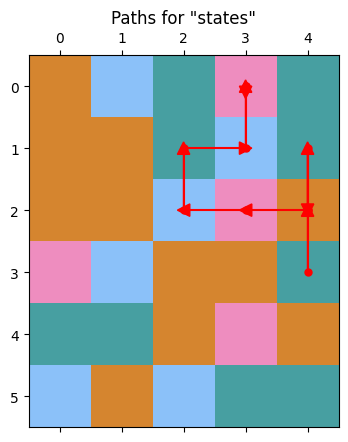

start, stop: (0, 10) 
 path original: [223, 97, 231, 74, 98, 154, 245, 206, 53, 53] 
 path: [26  9 27  5 10 18 29 24  2  2]


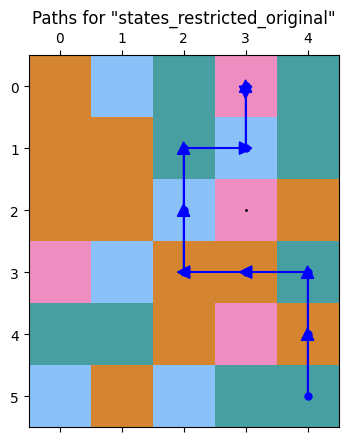

start, stop: (10, 20) 
 path: [ 53  53 206 245 154  92  75  92  74  98]


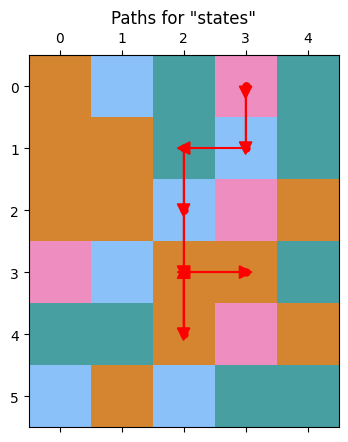

start, stop: (10, 20) 
 path original: [53, 53, 206, 245, 154, 92, 75, 92, 74, 98] 
 path: [ 2  2 24 29 18  8  6  8  5 10]


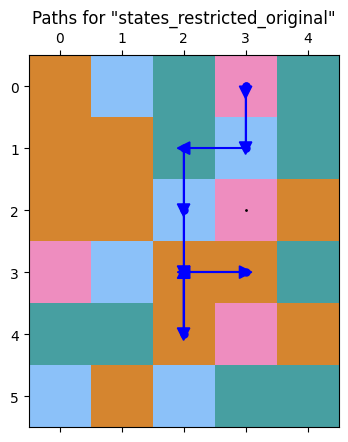

start, stop: (20, 30) 
 path: [ 74  58 246 223 223 223 223 223 246 178]


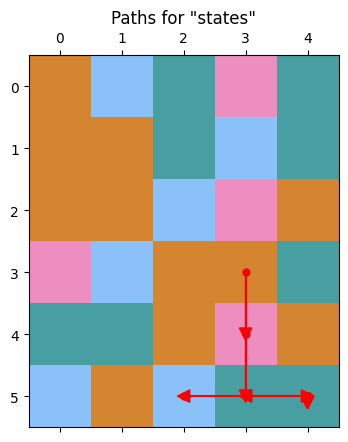

start, stop: (20, 30) 
 path original: [74, 58, 246, 223, 223, 223, 223, 223, 246, 178] 
 path: [ 5  3 30 26 26 26 26 26 30 23]


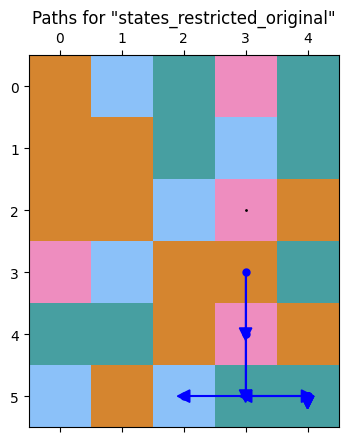

start, stop: (30, 40) 
 path: [178 246 223 246 246 178  73 258 148 130]


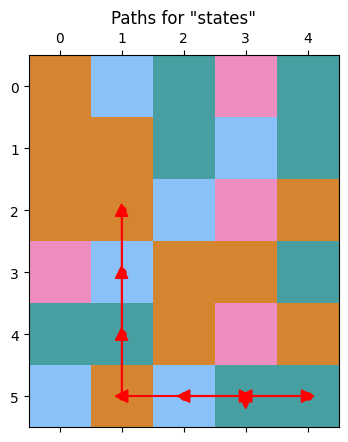

start, stop: (30, 40) 
 path original: [178, 246, 223, 246, 246, 178, 73, 258, 148, 130] 
 path: [23 30 26 30 30 23  4 32 17 16]


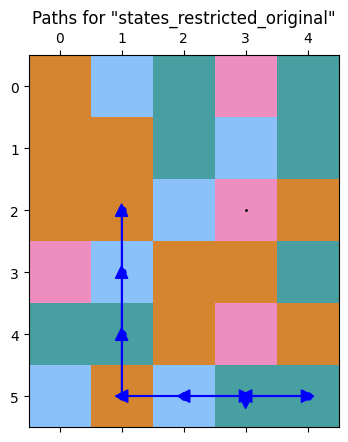

start, stop: (40, 50) 
 path: [154  92  75 178 178  75  58  97 231 231]


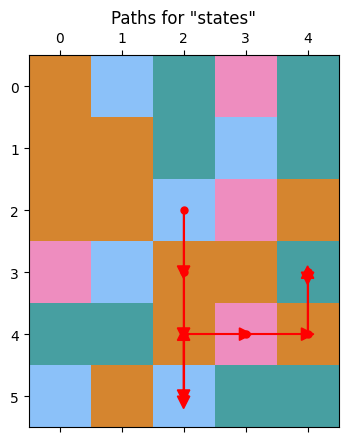

start, stop: (40, 50) 
 path original: [154, 92, 75, 178, 178, 75, 58, 97, 231, 231] 
 path: [18  8  6 23 23  6  3  9 27 27]


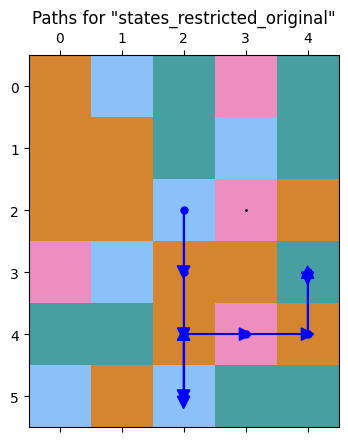

start, stop: (50, 60) 
 path: [108 231 108 231  97  58  74  98 154 245]


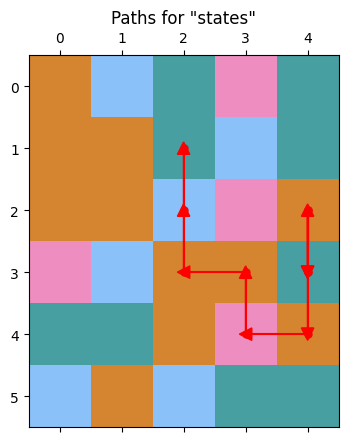

start, stop: (50, 60) 
 path original: [108, 231, 108, 231, 97, 58, 74, 98, 154, 245] 
 path: [13 27 13 27  9  3  5 10 18 29]


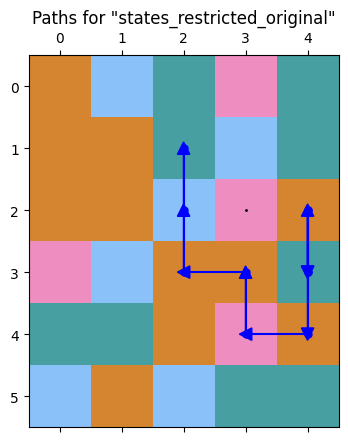

start, stop: (60, 70) 
 path: [105 113 107 174 105 113  88 130 154  10]


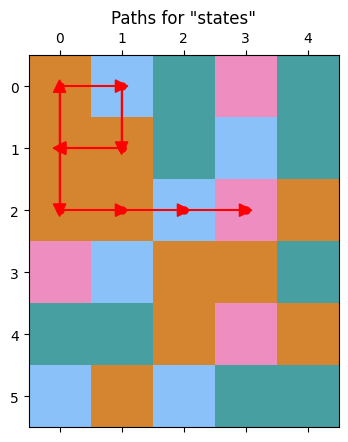

start, stop: (60, 70) 
 path original: [105, 113, 107, 174, 105, 113, 88, 130, 154, 92] 
 path: [11 15 12 22 11 15  7 16 18  8]


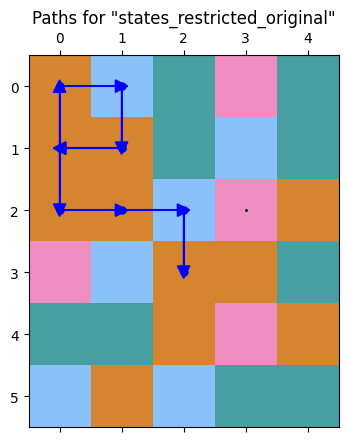

start, stop: (70, 80) 
 path: [154  10 154  10  74  58  74  58  74  58]


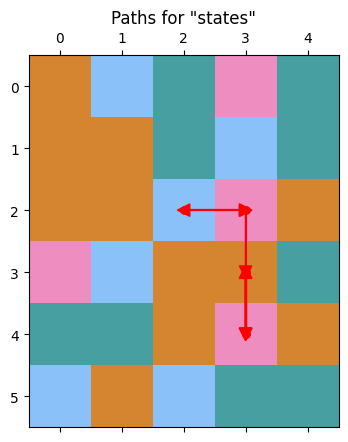

start, stop: (70, 80) 
 path original: [157, 98, 157, 98, 74, 58, 74, 58, 74, 58] 
 path: [19 10 19 10  5  3  5  3  5  3]


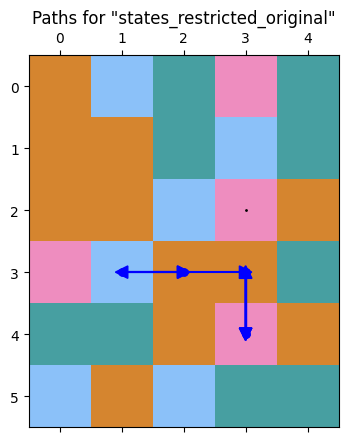

start, stop: (80, 90) 
 path: [ 75 178  75  92  74  98  75  58 246 246]


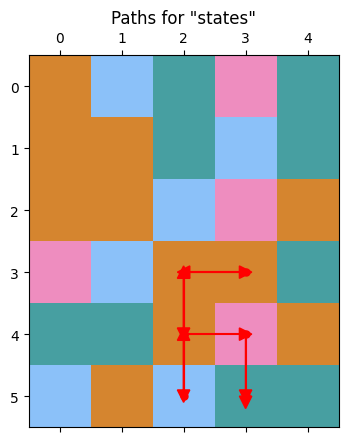

start, stop: (80, 90) 
 path original: [75, 178, 75, 92, 74, 98, 75, 58, 246, 246] 
 path: [ 6 23  6  8  5 10  6  3 30 30]


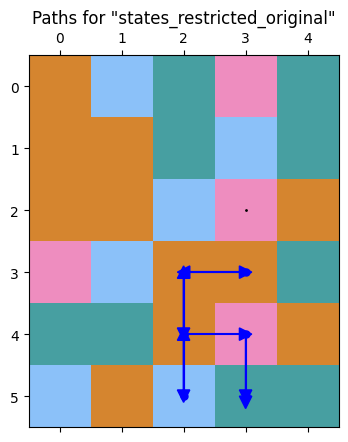

start, stop: (90, 100) 
 path: [223 223 223 223 223 223 223 246  58  97]


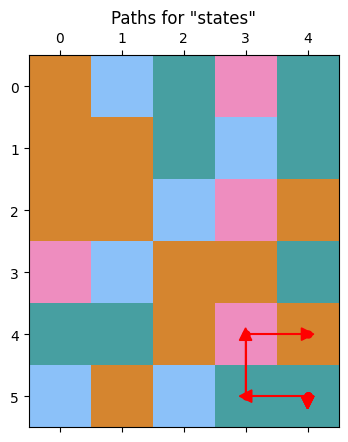

start, stop: (90, 100) 
 path original: [223, 223, 223, 223, 223, 223, 223, 246, 58, 97] 
 path: [26 26 26 26 26 26 26 30  3  9]


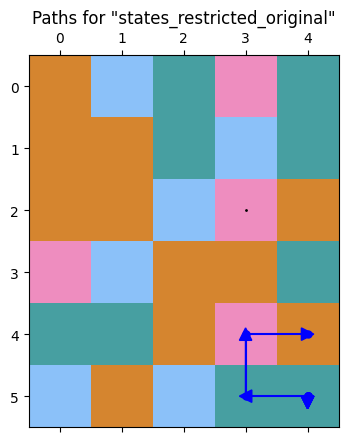

start, stop: (100, 110) 
 path: [ 97 223 223 223 223 223 223  97 223  97]


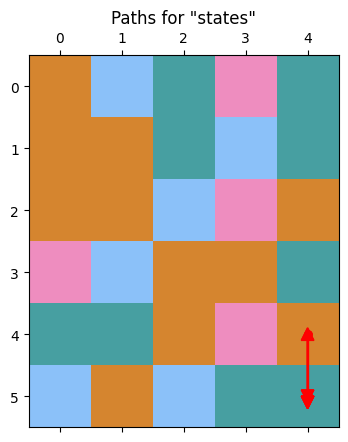

start, stop: (100, 110) 
 path original: [97, 223, 223, 223, 223, 223, 223, 97, 223, 97] 
 path: [ 9 26 26 26 26 26 26  9 26  9]


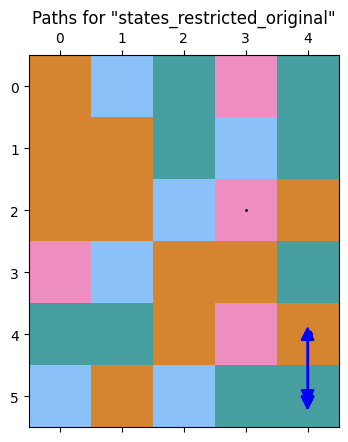

start, stop: (110, 120) 
 path: [223 223  97 223 246 223 223 246 246 178]


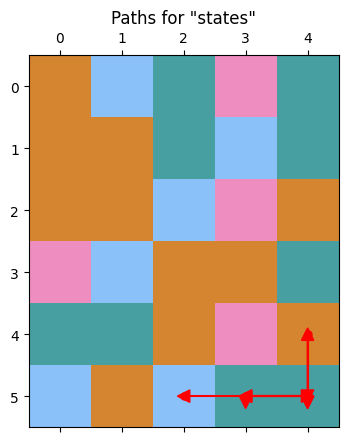

start, stop: (110, 120) 
 path original: [223, 223, 97, 223, 246, 223, 223, 246, 246, 178] 
 path: [26 26  9 26 30 26 26 30 30 23]


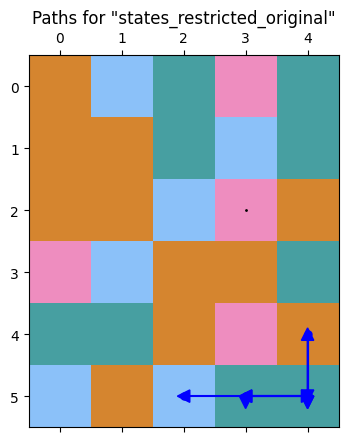

start, stop: (120, 130) 
 path: [246  58  75 178 246 178 178 178 178  73]


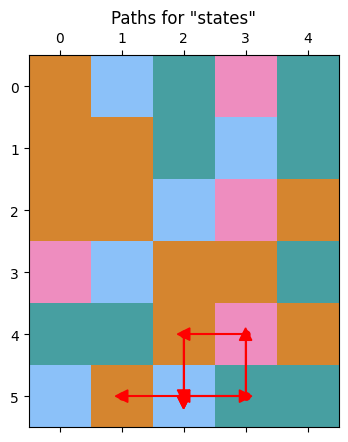

start, stop: (120, 130) 
 path original: [246, 58, 75, 178, 246, 178, 178, 178, 178, 73] 
 path: [30  3  6 23 30 23 23 23 23  4]


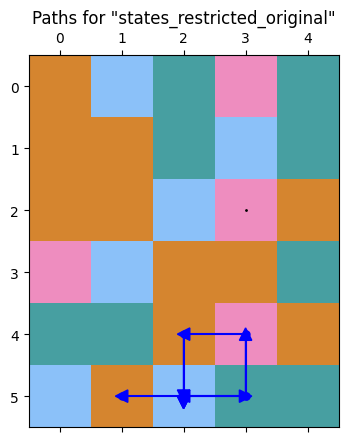

start, stop: (130, 140) 
 path: [171 171 214 214 214 214  11  11 214 214]


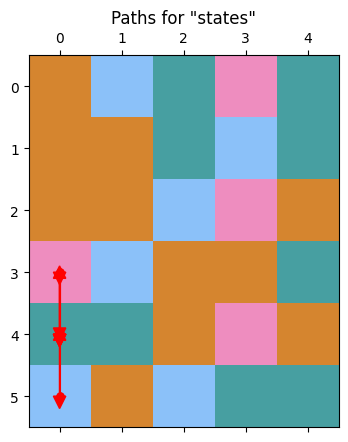

start, stop: (130, 140) 
 path original: [171, 171, 214, 214, 214, 214, 11, 11, 214, 214] 
 path: [21 21 25 25 25 25  1  1 25 25]


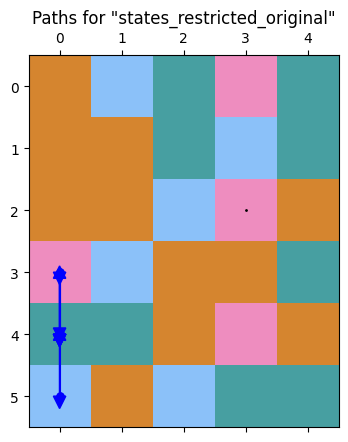

start, stop: (140, 150) 
 path: [171 171 171 214  11  88  88  11  88 113]


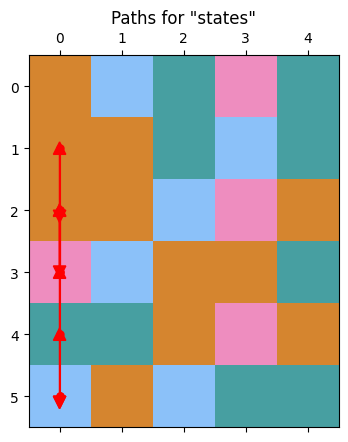

start, stop: (140, 150) 
 path original: [171, 171, 171, 214, 11, 88, 88, 11, 88, 113] 
 path: [21 21 21 25  1  7  7  1  7 15]


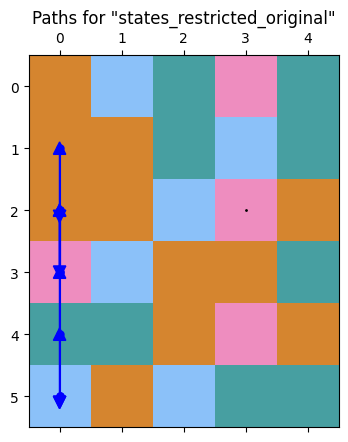

start, stop: (150, 160) 
 path: [113 107 107 174 169 247 169 105 169 107]


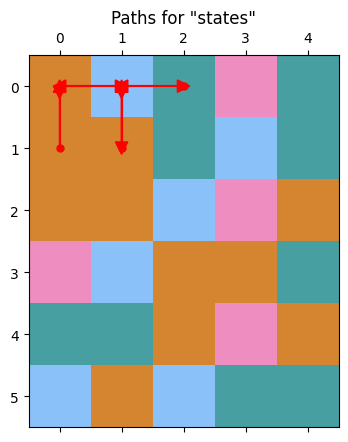

start, stop: (150, 160) 
 path original: [113, 107, 107, 174, 169, 247, 169, 105, 169, 107] 
 path: [15 12 12 22 20 31 20 11 20 12]


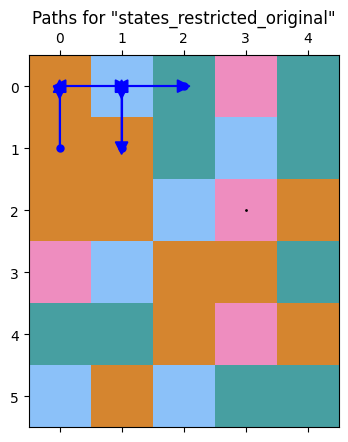

start, stop: (160, 170) 
 path: [113  88 130  88  11  88 113 105 130  88]


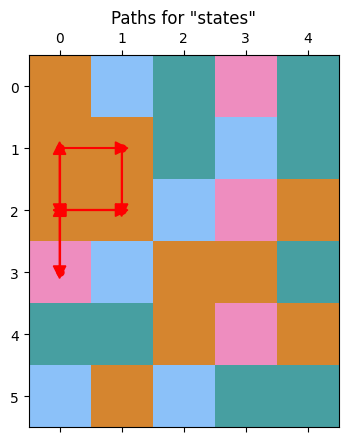

start, stop: (160, 170) 
 path original: [113, 88, 130, 88, 11, 88, 113, 105, 130, 88] 
 path: [15  7 16  7  1  7 15 11 16  7]


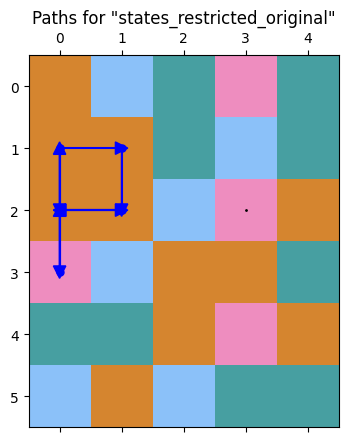

start, stop: (170, 180) 
 path: [113  88  11 157 130 105 113 107 107 107]


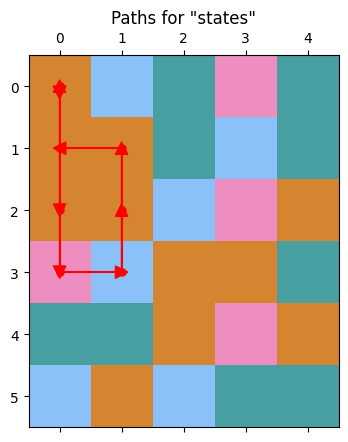

start, stop: (170, 180) 
 path original: [113, 88, 11, 157, 130, 105, 113, 107, 107, 107] 
 path: [15  7  1 19 16 11 15 12 12 12]


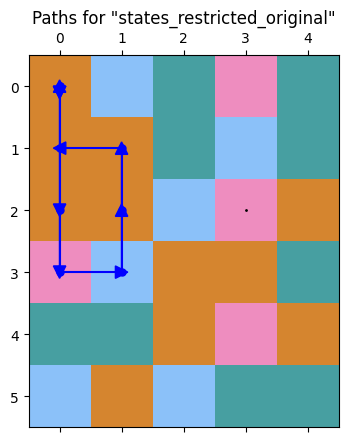

start, stop: (180, 190) 
 path: [174 169 107 107 174 169 169 247 247 247]


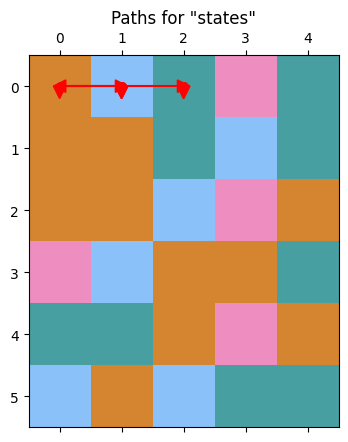

start, stop: (180, 190) 
 path original: [174, 169, 107, 107, 174, 169, 169, 247, 247, 247] 
 path: [22 20 12 12 22 20 20 31 31 31]


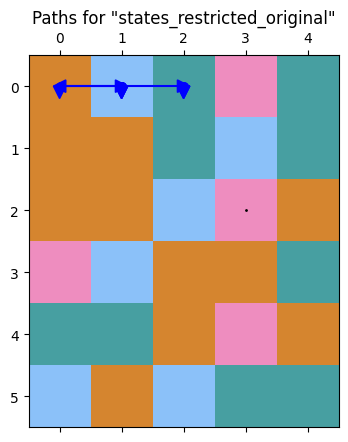

start, stop: (190, 200) 
 path: [169 169 169 247  53 206 245 247 247 245]


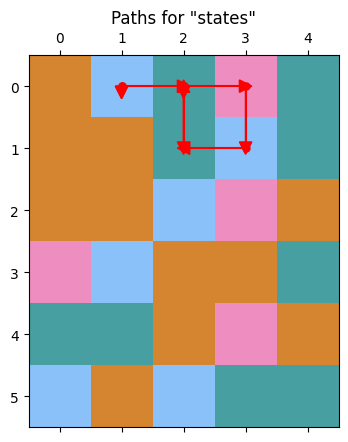

start, stop: (190, 200) 
 path original: [169, 169, 169, 247, 53, 206, 245, 247, 247, 245] 
 path: [20 20 20 31  2 24 29 31 31 29]


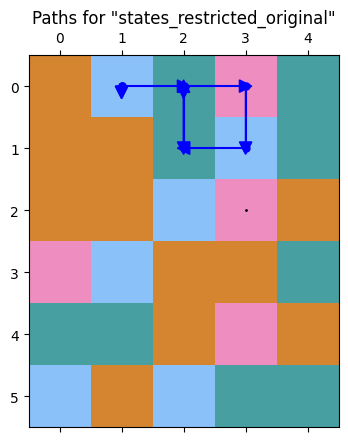

start, stop: (200, 210) 
 path: [247 169 105 113  88  11 157  11  88 113]


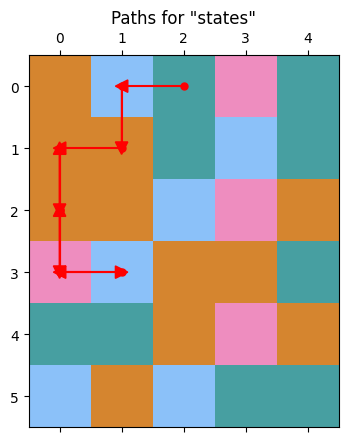

start, stop: (200, 210) 
 path original: [247, 169, 105, 113, 88, 11, 157, 11, 88, 113] 
 path: [31 20 11 15  7  1 19  1  7 15]


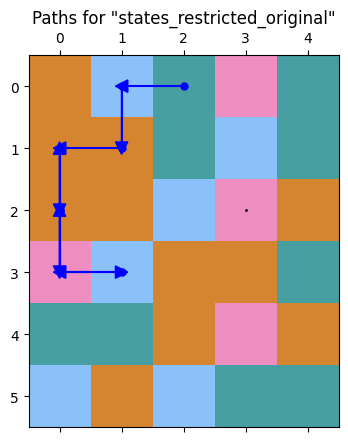

start, stop: (210, 220) 
 path: [113 107 107 107 113 113  88 113 107 107]


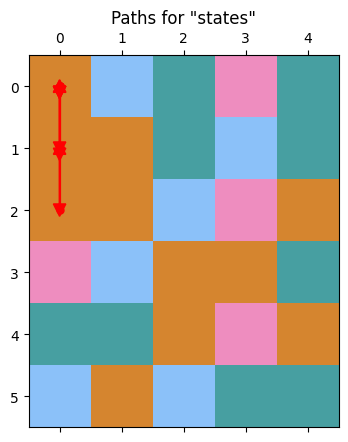

start, stop: (210, 220) 
 path original: [113, 107, 107, 107, 113, 113, 88, 113, 107, 107] 
 path: [15 12 12 12 15 15  7 15 12 12]


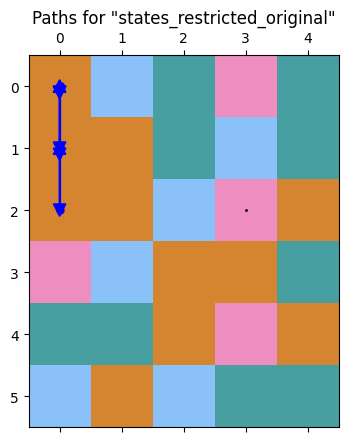

start, stop: (220, 230) 
 path: [174 105 245 206 245 206 245 105 245 154]


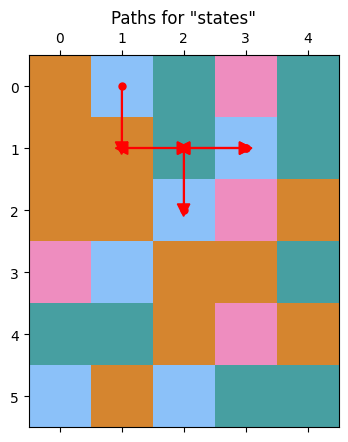

start, stop: (220, 230) 
 path original: [174, 105, 245, 206, 245, 206, 245, 105, 245, 154] 
 path: [22 11 29 24 29 24 29 11 29 18]


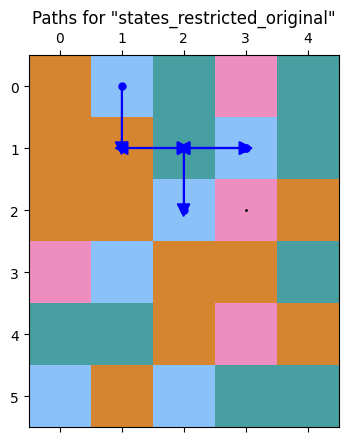

start, stop: (230, 240) 
 path: [ 92  75 178 178 246 223  97 223 223  97]


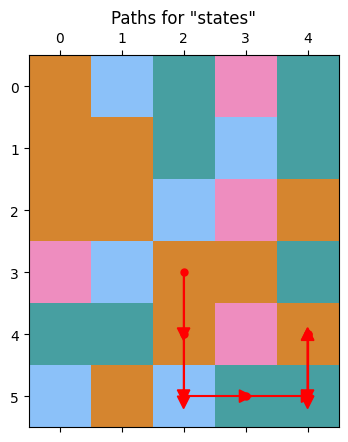

start, stop: (230, 240) 
 path original: [92, 75, 178, 178, 246, 223, 97, 223, 223, 97] 
 path: [ 8  6 23 23 30 26  9 26 26  9]


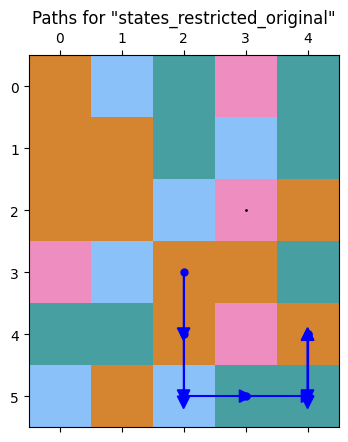

start, stop: (240, 250) 
 path: [223 246  58  97  58  75 258 148  92 157]


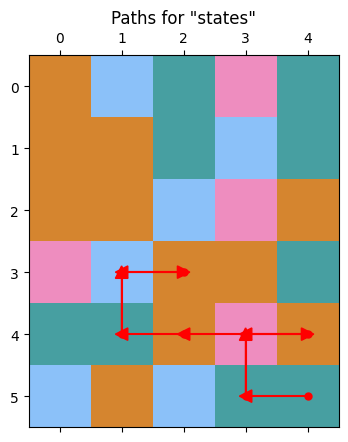

start, stop: (240, 250) 
 path original: [223, 246, 58, 97, 58, 75, 258, 148, 92, 157] 
 path: [26 30  3  9  3  6 32 17  8 19]


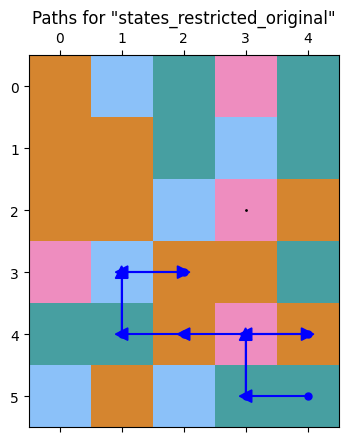

start, stop: (250, 260) 
 path: [258 214 214  11  88 130 157 130  88 130]


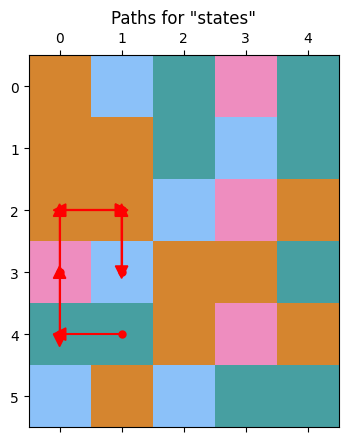

start, stop: (250, 260) 
 path original: [258, 214, 214, 11, 88, 130, 157, 130, 88, 130] 
 path: [32 25 25  1  7 16 19 16  7 16]


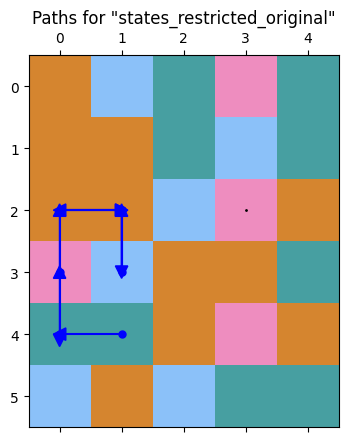

start, stop: (260, 270) 
 path: [ 88  88 113 105 130 157 130 105 245 154]


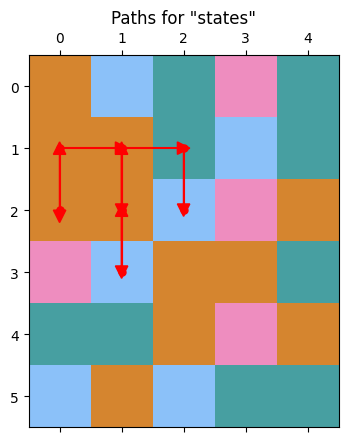

start, stop: (260, 270) 
 path original: [88, 88, 113, 105, 130, 157, 130, 105, 245, 154] 
 path: [ 7  7 15 11 16 19 16 11 29 18]


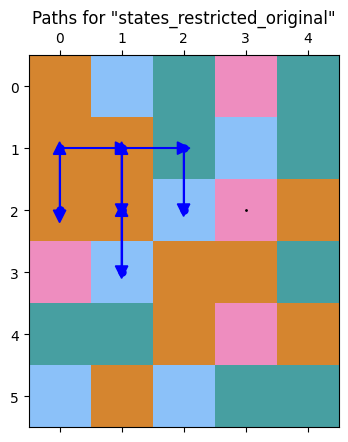

start, stop: (270, 280) 
 path: [ 92  75 258  73 171 109 171 109  73  73]


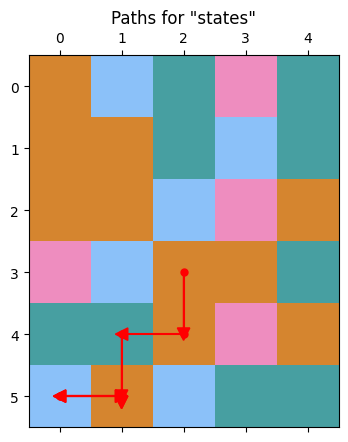

start, stop: (270, 280) 
 path original: [92, 75, 258, 73, 171, 109, 171, 109, 73, 73] 
 path: [ 8  6 32  4 21 14 21 14  4  4]


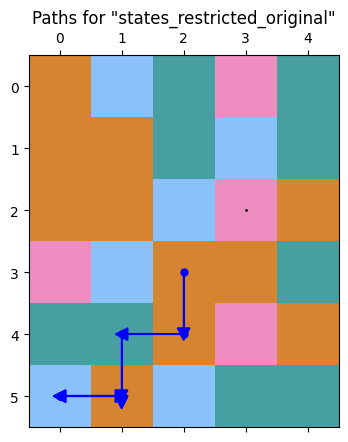

start, stop: (280, 290) 
 path: [178  75  58  74  98 157  11 214 214  11]


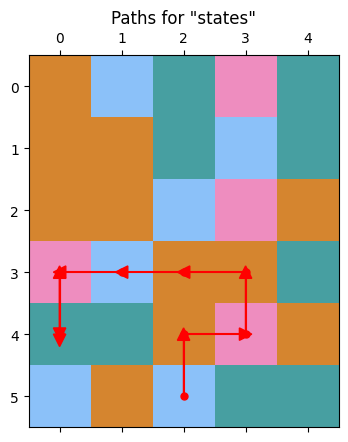

start, stop: (280, 290) 
 path original: [178, 75, 58, 74, 98, 157, 11, 214, 214, 11] 
 path: [23  6  3  5 10 19  1 25 25  1]


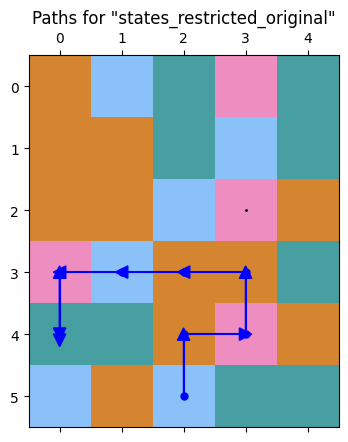

start, stop: (290, 300) 
 path: [ 11 157  98  75  58  74  98  75 258 214]


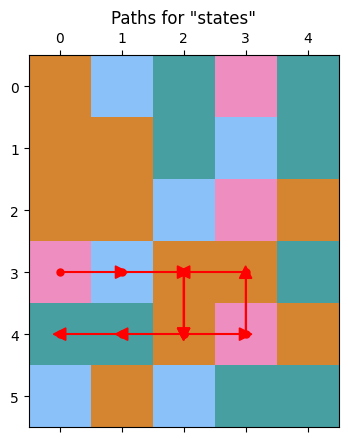

start, stop: (290, 300) 
 path original: [11, 157, 98, 75, 58, 74, 98, 75, 258, 214] 
 path: [ 1 19 10  6  3  5 10  6 32 25]


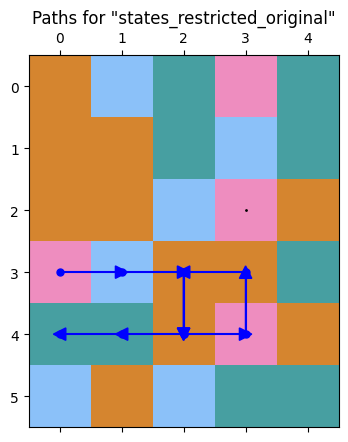

start, stop: (300, 310) 
 path: [ 11 157  98 157 258  75 178 246 246  58]


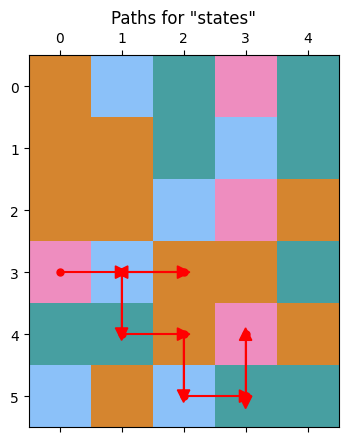

start, stop: (300, 310) 
 path original: [11, 157, 98, 157, 258, 75, 178, 246, 246, 58] 
 path: [ 1 19 10 19 32  6 23 30 30  3]


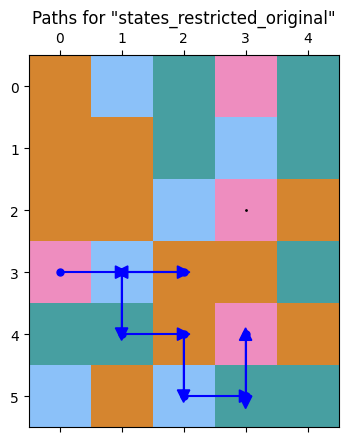

start, stop: (310, 320) 
 path: [246  58  74  58  74  98 154  10  74  98]


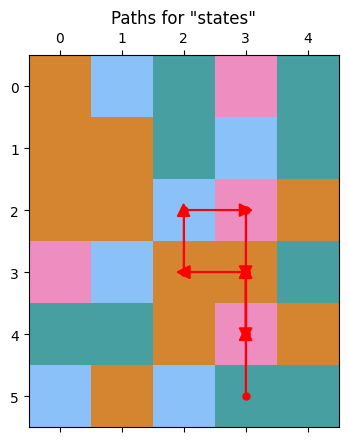

start, stop: (310, 320) 
 path original: [246, 58, 74, 58, 74, 98, 154, 92, 74, 98] 
 path: [30  3  5  3  5 10 18  8  5 10]


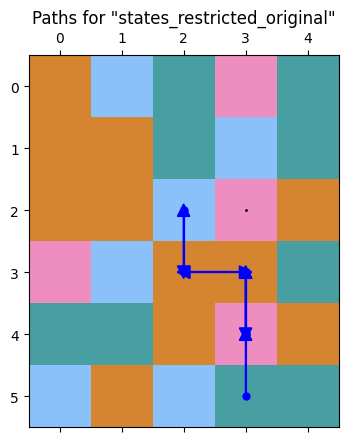

start, stop: (320, 330) 
 path: [ 75  58  97  97 231 108 231  97  58  75]


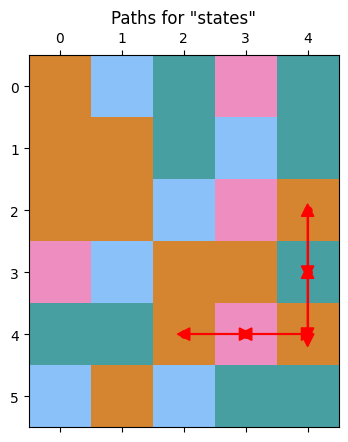

start, stop: (320, 330) 
 path original: [75, 58, 97, 97, 231, 108, 231, 97, 58, 75] 
 path: [ 6  3  9  9 27 13 27  9  3  6]


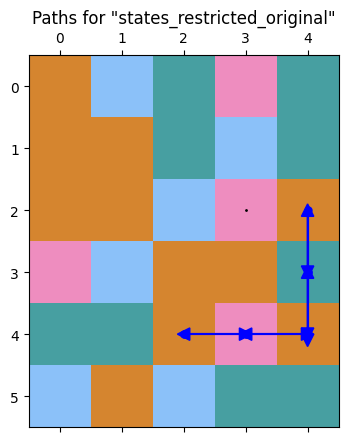

start, stop: (330, 340) 
 path: [178  75  58 246 178  75 178 178  75 178]


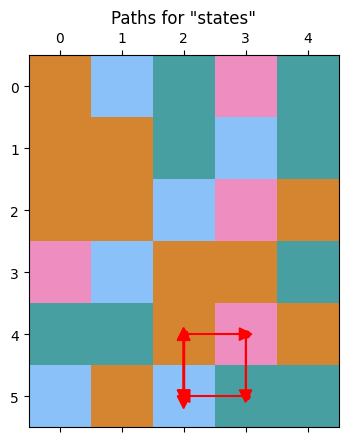

start, stop: (330, 340) 
 path original: [178, 75, 58, 246, 178, 75, 178, 178, 75, 178] 
 path: [23  6  3 30 23  6 23 23  6 23]


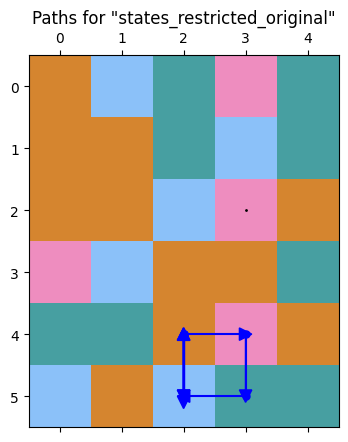

start, stop: (340, 350) 
 path: [ 75  58  74  10 206  10  74  10  74  98]


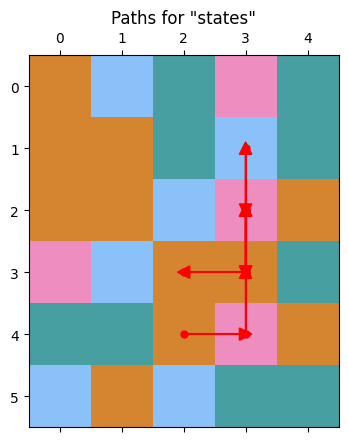

start, stop: (340, 350) 
 path original: [75, 58, 74, 98, 154, 92, 75, 92, 74, 98] 
 path: [ 6  3  5 10 18  8  6  8  5 10]


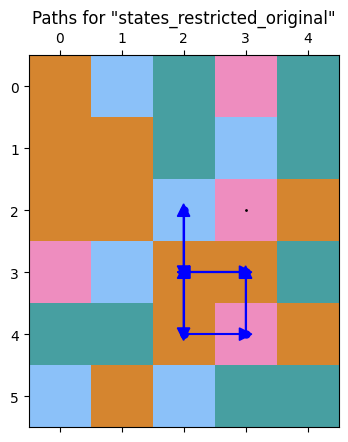

start, stop: (350, 360) 
 path: [157 258  73 258  75 178  73 258  73 171]


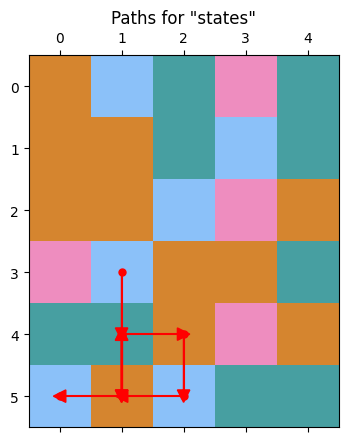

start, stop: (350, 360) 
 path original: [157, 258, 73, 258, 75, 178, 73, 258, 73, 171] 
 path: [19 32  4 32  6 23  4 32  4 21]


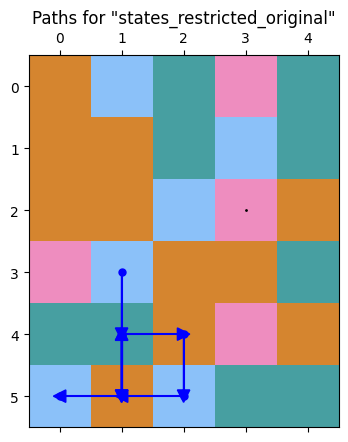

start, stop: (360, 370) 
 path: [171 109 258 148  92  74  10 206  10  74]


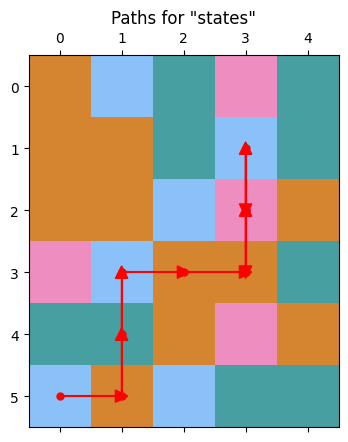

start, stop: (360, 370) 
 path original: [171, 109, 258, 148, 92, 74, 98, 154, 92, 74] 
 path: [21 14 32 17  8  5 10 18  8  5]


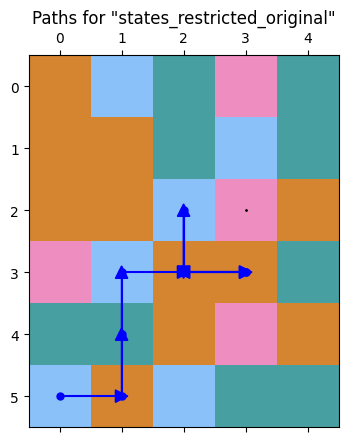

start, stop: (370, 380) 
 path: [231  97  58 246 246 178 246 178 178 246]


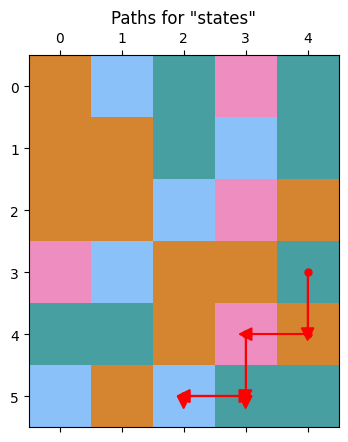

start, stop: (370, 380) 
 path original: [231, 97, 58, 246, 246, 178, 246, 178, 178, 246] 
 path: [27  9  3 30 30 23 30 23 23 30]


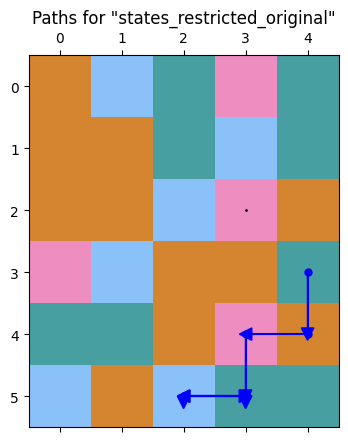

start, stop: (380, 390) 
 path: [246 178  73  73 258 148  11  11  88 113]


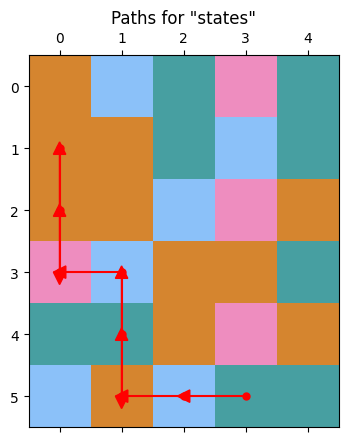

start, stop: (380, 390) 
 path original: [246, 178, 73, 73, 258, 148, 11, 11, 88, 113] 
 path: [30 23  4  4 32 17  1  1  7 15]


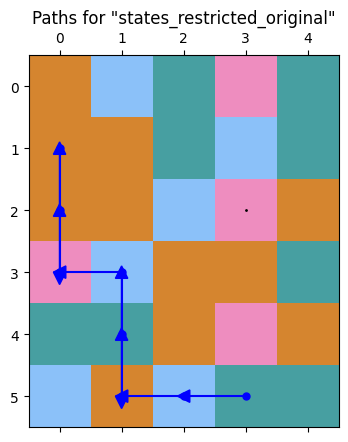

start, stop: (390, 400) 
 path: [ 88  11  88  11 214 258  73 171 171 171]


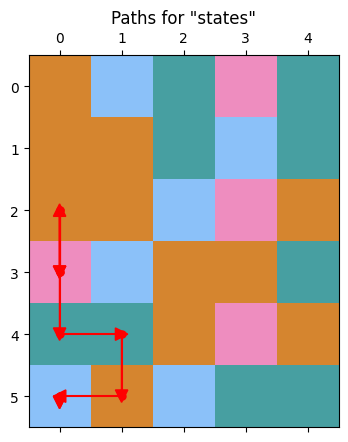

start, stop: (390, 400) 
 path original: [88, 11, 88, 11, 214, 258, 73, 171, 171, 171] 
 path: [ 7  1  7  1 25 32  4 21 21 21]


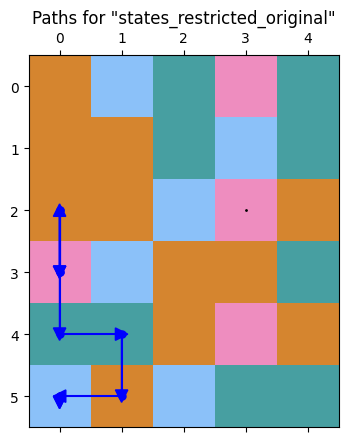

start, stop: (400, 410) 
 path: [214 214 171 171 109  73  73 178  75 178]


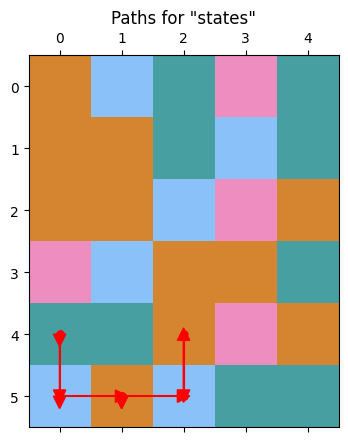

start, stop: (400, 410) 
 path original: [214, 214, 171, 171, 109, 73, 73, 178, 75, 178] 
 path: [25 25 21 21 14  4  4 23  6 23]


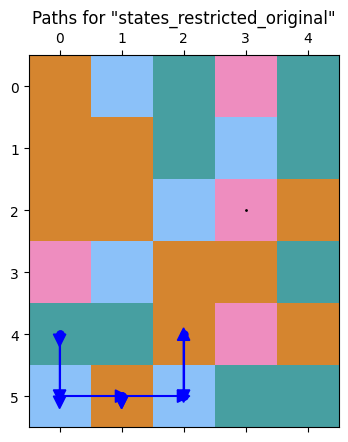

start, stop: (410, 420) 
 path: [246 178  75 258 214 258  73 178 246 223]


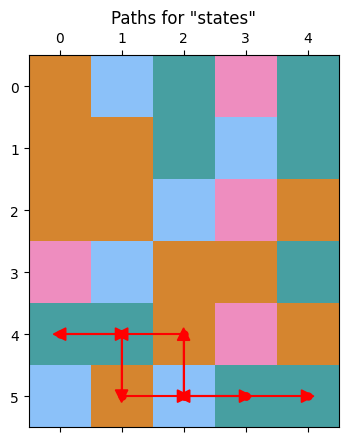

start, stop: (410, 420) 
 path original: [246, 178, 75, 258, 214, 258, 73, 178, 246, 223] 
 path: [30 23  6 32 25 32  4 23 30 26]


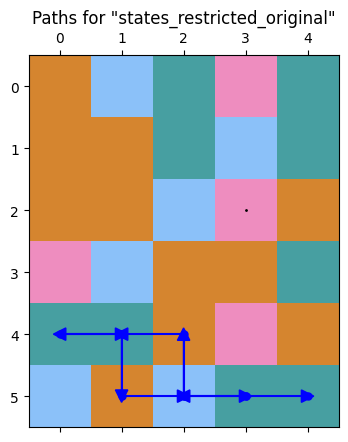

start, stop: (420, 430) 
 path: [223  97 223 246 178 178  73  73 171 109]


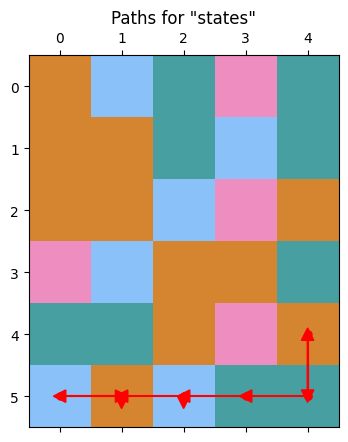

start, stop: (420, 430) 
 path original: [223, 97, 223, 246, 178, 178, 73, 73, 171, 109] 
 path: [26  9 26 30 23 23  4  4 21 14]


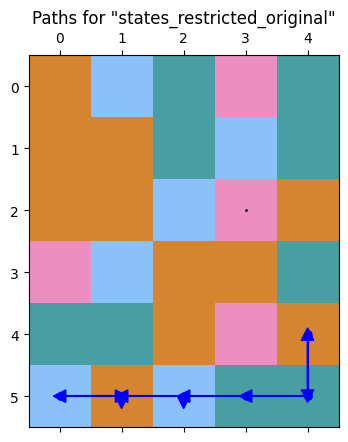

start, stop: (430, 440) 
 path: [171 171 171 171 171 171 214  11  11 214]


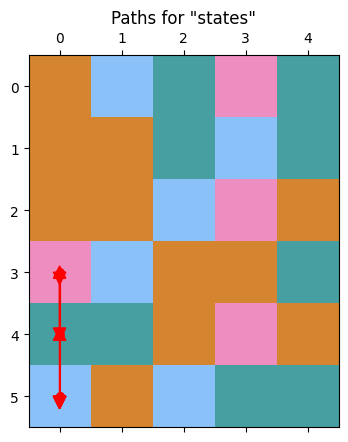

start, stop: (430, 440) 
 path original: [171, 171, 171, 171, 171, 171, 214, 11, 11, 214] 
 path: [21 21 21 21 21 21 25  1  1 25]


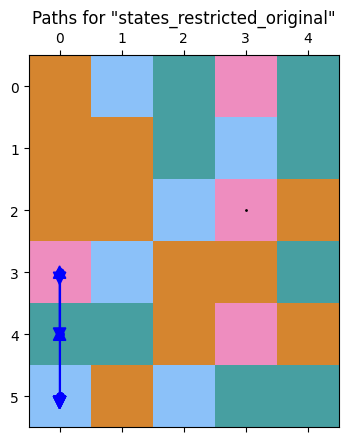

start, stop: (440, 450) 
 path: [214 171 171 214  11 157 130 154  10 108]


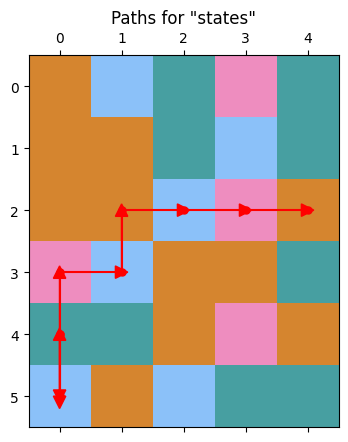

start, stop: (440, 450) 
 path original: [214, 171, 171, 214, 11, 157, 130, 154, 108, 108] 
 path: [25 21 21 25  1 19 16 18 13 13]


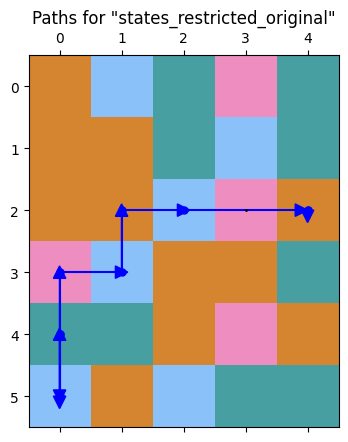

start, stop: (450, 460) 
 path: [108 108  10 206 234 108 234 276 276  53]


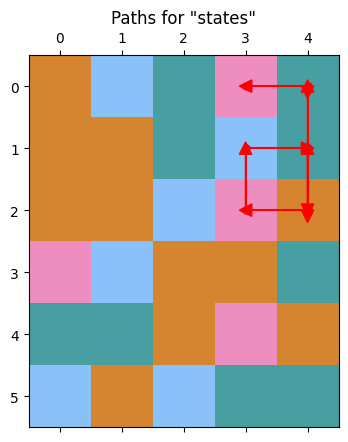

start, stop: (450, 460) 
 path original: [108, 108, 234, 206, 234, 108, 234, 276, 276, 53] 
 path: [13 13 28 24 28 13 28 33 33  2]


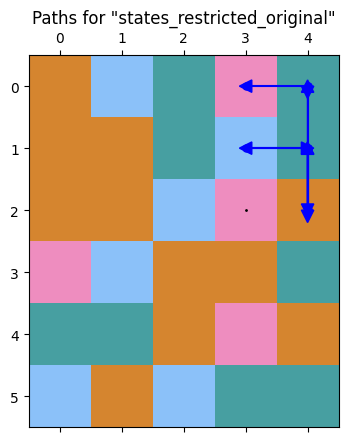

start, stop: (460, 470) 
 path: [276  53 206  53 206 245 105 130  88  11]


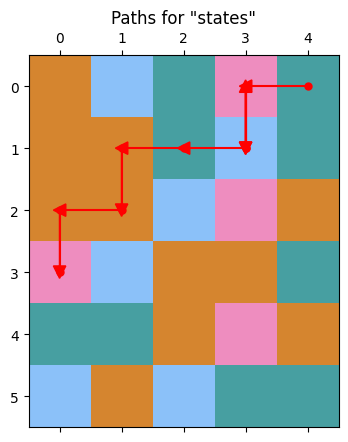

start, stop: (460, 470) 
 path original: [276, 53, 206, 53, 206, 245, 105, 130, 88, 11] 
 path: [33  2 24  2 24 29 11 16  7  1]


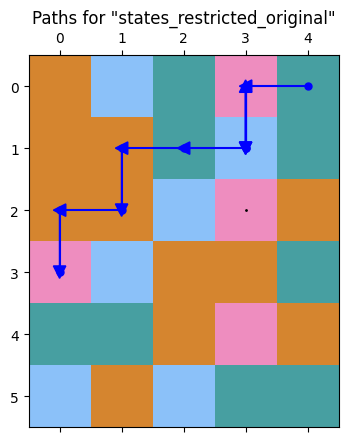

start, stop: (470, 480) 
 path: [ 88  11  88  11  11 214 214 171 171 109]


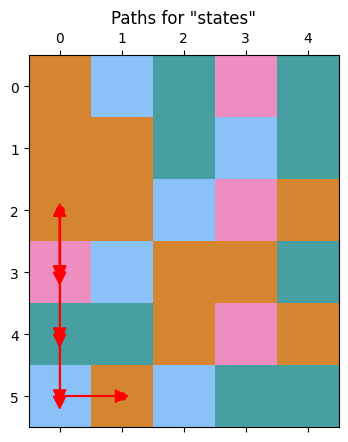

start, stop: (470, 480) 
 path original: [88, 11, 88, 11, 11, 214, 214, 171, 171, 109] 
 path: [ 7  1  7  1  1 25 25 21 21 14]


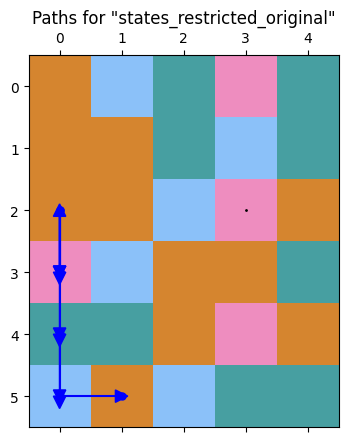

start, stop: (480, 490) 
 path: [171 109 171 109 258  73 171 171 171 171]


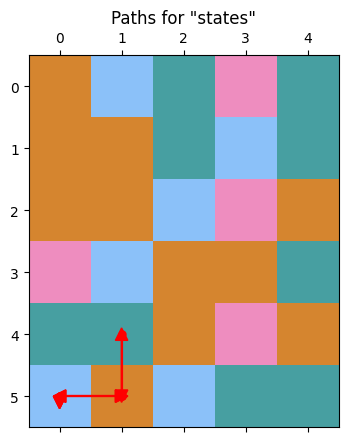

start, stop: (480, 490) 
 path original: [171, 109, 171, 109, 258, 73, 171, 171, 171, 171] 
 path: [21 14 21 14 32  4 21 21 21 21]


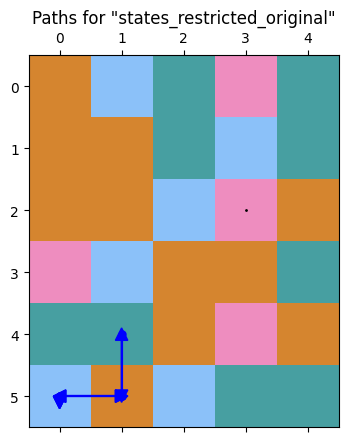

start, stop: (490, 500) 
 path: [171 109 171 214  11 214 214 171 214 214]


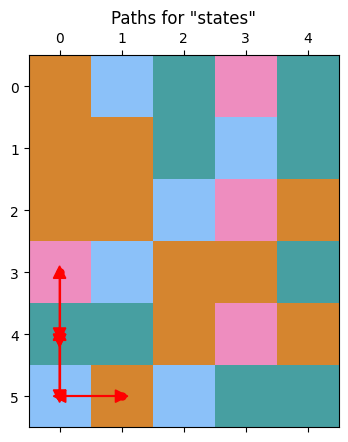

start, stop: (490, 500) 
 path original: [171, 109, 171, 214, 11, 214, 214, 171, 214, 214] 
 path: [21 14 21 25  1 25 25 21 25 25]


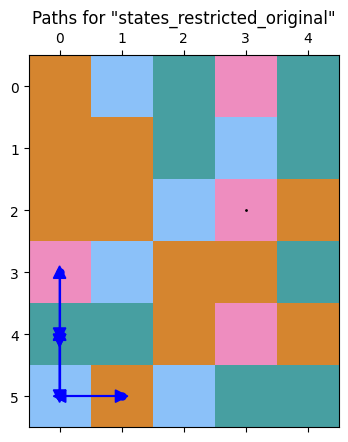

In [ ]:
#Looping over the whole sequence to plot the recreated paths on the reconstructed room.

j_blocked = clones_blocked_original



for i in range(50):

  start = 10*i
  stop = 10*(i+1)


  active_clones = np.unique(states)

  #if j_blocked[0] in states[start:stop]:

  # Extract paths for 'states'
  print("start, stop:", (start, stop), "\n path:", states[start:stop])
  ijs = []
  for state in states[start:stop]:
      idx_clone = np.argwhere(active_clones == state)[0][0]
      ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
      ijs.append(ij)

  # Create the room plot for 'states'
  room_plot_states = plt.matshow(reconstructed_room, cmap=cmap)

  # Plot 'states' path in red
  x_coords, y_coords = zip(*ijs)
  plt.plot(x_coords, y_coords, color='red', marker='o', markersize=5)

  for i in range(len(ijs) - 1):
      x_start, y_start = ijs[i]
      x_end, y_end = ijs[i + 1]
      dx = x_end - x_start
      dy = y_end - y_start
      plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='red', ec='red')

  plt.title('Paths for "states"')
  plt.show()


  # Extract paths for 'states_restricted_original'
  print("start, stop:", (start, stop), "\n path original:", states_restricted_original[start:stop],
        "\n path:", statesE_restricted_blocked[start:stop])
  ijs_blocked = []
  for state in states_restricted_original[start:stop]:
      idx_clone = np.argwhere(active_clones == state)[0][0]
      ij = (ijs_max[idx_clone][1], ijs_max[idx_clone][0])
      ijs_blocked.append(ij)

  # Create the room plot for 'states_bwd'
  room_plot_states_blocked = plt.matshow(reconstructed_room, cmap=cmap)

  # Plot 'states_bwd' path in blue
  x_coords_blocked, y_coords_blocked = zip(*ijs_blocked)
  plt.plot(x_coords_blocked, y_coords_blocked, color='blue', marker='o', markersize=5)

  for i in range(len(ijs_blocked) - 1):
      x_start, y_start = ijs_blocked[i]
      x_end, y_end = ijs_blocked[i + 1]
      dx = x_end - x_start
      dy = y_end - y_start
      plt.arrow(x_start, y_start, dx * 0.9, dy * 0.9, head_width=0.2, head_length=0.2, fc='blue', ec='blue')

  for j_idx in j_blocked:
      j_node = np.argwhere(v == j_idx)[0][0]
      j_ij = (ijs_max[j_node][1], ijs_max[j_node][0])
      plt.plot(j_ij[0], j_ij[1], color='black', marker='o', markersize=1)

  plt.title('Paths for "states_restricted_original"')
  plt.show()


In [ ]:
#Rewriting forward and backtrace functions to block graph states and allow for sequence extraction on states in the graph.



def forward_mp_extract(T_tr, Pi, n_clones, x, a, store_messages=False):
    """Log-probability of a sequence, and optionally, messages"""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    dtype = T_tr.dtype.type

    # forward pass
    t, log2_lik = 0, np.zeros(len(x), dtype)
    j = x[t]
    j_start, j_stop = state_loc[j : j + 2]
    message = Pi[j_start:j_stop].copy().astype(dtype)
    p_obs = message.max()
    #print("p_obs", p_obs)
    assert p_obs > 0
    message /= p_obs
    #print("message", message)
    log2_lik[0] = np.log2(p_obs)
    if store_messages:
        mess_loc = np.hstack(
            (np.array([0], dtype=n_clones.dtype), n_clones[x])
        ).cumsum()
        mess_fwd = np.empty(mess_loc[-1], dtype=dtype)
        t_start, t_stop = mess_loc[t : t + 2]
        #print("t_start, t_stop", t_start, t_stop)
        mess_fwd[t_start:t_stop] = message
    else:
        mess_fwd = None

    for t in range(1, x.shape[0]):
        aij, i, j = (
            a[t - 1],
            x[t - 1],
            x[t],
        )
        #print("aij, i, j:", aij, i, j)  # at time t-1 -> t we go from observation i to observation j
        (i_start, i_stop), (j_start, j_stop) = (
            state_loc[i : i + 2],
            state_loc[j : j + 2],
        )
        #print("(i_start, i_stop), (j_start, j_stop)", (i_start, i_stop), (j_start, j_stop))
        new_message = np.zeros(j_stop - j_start, dtype=dtype)
        #print("len(new_message)", len(new_message))
        for d in range(len(new_message)):
            new_message[d] = (T_tr[aij, j_start + d, i_start:i_stop] * message).max()
        #print("new_message", new_message)
        message = new_message
        p_obs = message.max()
        #print("p_obs", p_obs)
        assert p_obs > 0
        message /= p_obs
        #print("message", message)
        log2_lik[t] = np.log2(p_obs)
        if store_messages:
            t_start, t_stop = mess_loc[t : t + 2]
            #print("t_start, t_stop", t_start, t_stop)
            mess_fwd[t_start:t_stop] = message
            #print("mess_fwd[t_start:t_stop]", mess_fwd[t_start:t_stop])
            #print("\n")
    return log2_lik, mess_fwd


def rargmax_2(x, exclude=None):
    if exclude is None:
        exclude = []
    valid_indices = np.setdiff1d((x == x.max()).nonzero()[0], exclude)
    if len(valid_indices) > 0:
        return np.random.choice(valid_indices)
    return None  # Return None if no valid indices are found




def backtrace(T, n_clones, x, a, mess_fwd, active_clones, default_value=0):
    """Compute backward messages."""
    state_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones)).cumsum()
    #print("state_loc.shape", state_loc.shape)
    mess_loc = np.hstack((np.array([0], dtype=n_clones.dtype), n_clones[x])).cumsum()
    #print("mess_loc.shape", mess_loc.shape)
    code = np.zeros(x.shape[0], dtype=np.int64)

    # backward pass
    t = x.shape[0] - 1
    i = x[t]
    t_start, t_stop = mess_loc[t : t + 2]
    #print("t_start, t_stop", t_start, t_stop)
    belief = mess_fwd[t_start:t_stop]
    #print("belief", belief)
    code[t] = rargmax(belief)
    #print("code[t]", code[t])
    for t in range(x.shape[0] - 2, -1, -1):
        aij, i, j = (
            a[t],
            x[t],
            x[t + 1],
        )  # at time t -> t+1 we go from observation i to observation j
        (i_start, i_stop), j_start = state_loc[i : i + 2], state_loc[j]
        #print("(i_start, i_stop), j_start", (i_start, i_stop), j_start)
        t_start, t_stop = mess_loc[t : t + 2]
        #print("t_start, t_stop", t_start, t_stop)
        excluded_indices = []
        while True:
            belief = mess_fwd[t_start:t_stop] * T[aij, i_start:i_stop, j_start + code[t + 1]]
            current_max = rargmax_2(belief, exclude=excluded_indices)

            if current_max is None or current_max in active_clones:
                break  # Exit loop if no more max values or a valid code[t] is found

            excluded_indices.append(current_max)  # Add to excluded list for next iteration

        code[t] = current_max if current_max is not None else default_value  # Set code[t] or a default value


        #print("belief", belief)
        #print("code[t]", code[t])
    states = state_loc[x] + code
    #print("state_loc[x]", state_loc[x])
    #print("states"), states
    return states

In [ ]:
E.shape

(280, 4)

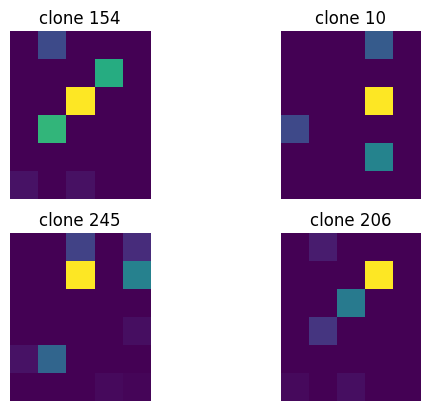

In [ ]:
clone_indices = [154, 10, 245, 206]   # This needs to be changed to pick an actual number from the graph
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

# Note that the place field has weak repetitions in locations where the same observations occur.
# Changing the smoothing value in mess_fwd computation will change the strength of these 'side lobes'

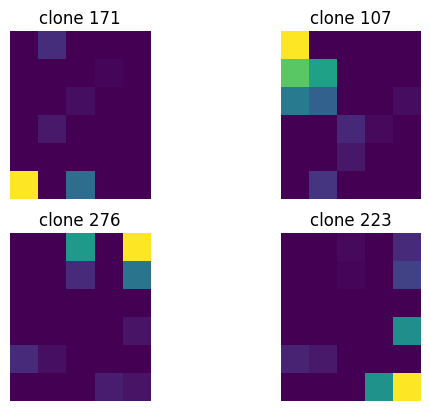

In [ ]:
# Place fields in the 4 corners
clone_indices = [171, 107, 276, 223]   # This needs to be changed to pick an actual number from the graph
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")


# Place fields in empty rectangular room

---



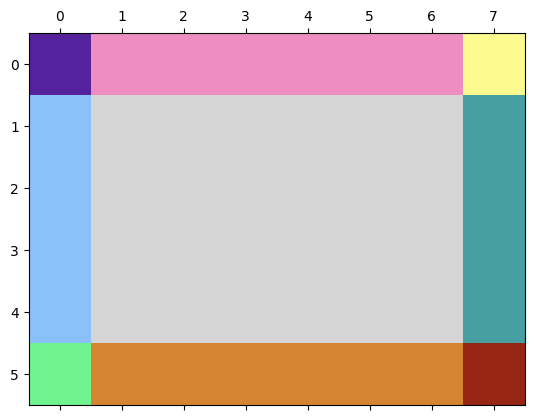

In [ ]:
# Create the room layout and visualize
H, W = 6, 8
room = np.zeros((H, W), dtype=np.int64)
room[:] = 0
room[0] = 5
room[-1] = 6
room[:, 0] = 7
room[:, -1] = 8
room[0, 0] = 1
room[0, -1] = 2
room[-1, 0] = 3
room[-1, -1] = 4
cmap = colors.ListedColormap(custom_colors)
plt.matshow(room, cmap=cmap)
plt.savefig("figures/empty_rectangular_room_layout.pdf")

In [ ]:
# Generate random walk data from the above room and train a CSCG. Takes about a minute.
a, x, rc = datagen_structured_obs_room(room, length=10000)  # Make length = 50000 for better learning

# Create and train CSCG
n_emissions = room.max() + 1
n_clones = np.ones(n_emissions, dtype=np.int64) * 70
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=4)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=100)  # Training  # Make n_iter=1000 for better learning of the model.

Average number of clones: 70.0


100%|██████████| 100/100 [00:56<00:00,  1.76it/s, train_bps=0.108]


In [ ]:
# refine learning. Takes a few seconds
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

 17%|█▋        | 17/100 [00:03<00:18,  4.45it/s, train_bps=0.112]


[0.26075152,
 0.14085497,
 0.13071701,
 0.12842886,
 0.124864124,
 0.117370084,
 0.11456924,
 0.11387909,
 0.11360298,
 0.11349183,
 0.113413855,
 0.113360256,
 0.11327521,
 0.11237647,
 0.1121031,
 0.11208186,
 0.11208009,
 0.11208009]

In [ ]:
graph = plot_graph(
    chmm, x, a, output_file="figures/empty_rectangular_room_graph.pdf", cmap=cmap, vertex_size=30
)
graph

# CSCG learned an approximate model of the room. Note that the room size is not correct.

(<igraph.drawing.Plot at 0x7e0b703b7d90>, array([28, 26,  0, ..., 42, 66, 42]))

In [ ]:
# Compute the sequene of neuron activations
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=1e-10)

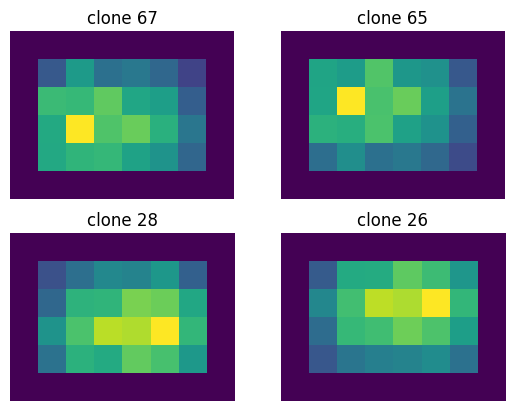

In [ ]:
clone_indices = [67, 65, 28, 26]   # These numbers are picked from the graph above
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

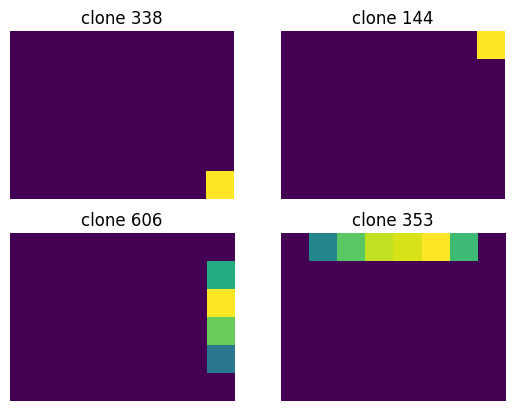

In [ ]:
clone_indices = [338, 144, 606, 353]   # Two corner neurons, two edge neurons
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

In [ ]:
# Note above that the place fields in the middle are large and more imprecise.
# Place fields along the edges are elongated along the edge.
# And place field in the corner is small and precise.

In [ ]:
# Generate longer data sequence and run training for more iterations to learn a better model.
# WARNING: This can take about 20 minutes.

n_clones = np.ones(n_emissions, dtype=np.int64) * 70
a, x, rc = datagen_structured_obs_room(room, length=50000)
chmm = CHMM(n_clones=n_clones, pseudocount=2e-3, x=x, a=a, seed=4)  # Initialize the model

progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training

# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)

graph = plot_graph(
    chmm, x, a, output_file="figures/empty_rectangular_room_graph.pdf", cmap=cmap, vertex_size=30
)
graph

Average number of clones: 70.0


  1%|▏         | 13/1000 [00:24<30:41,  1.87s/it, train_bps=0.538]


KeyboardInterrupt: ignored

In [ ]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=1e-10)

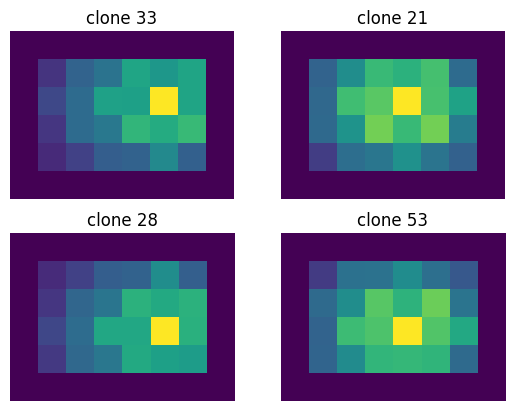

In [ ]:
clone_indices = [33, 21, 28, 53]   # 4 neurons in the middle of the room
for i in range(4):
  plt.subplot(2,2,i+1)
  plt.axis('off')
  plt.imshow(place_field(mess_fwd, rc, clone_indices[i]))
  plt.title('clone '+str(clone_indices[i]))
plt.savefig("figures/rectangular_room_place_fields.pdf")

# Note that the neuron fields are more precise with more learning. Also the learned graph represents the room perfectly.

# Transitive learning. From disjoint experience in two overlapping rooms, CSCG learns a coherent unified model.

In [ ]:
room1 = np.array(
    [
        [12, 4, 0, 1, 13, 2],
        [7, 3, 12, 11, 0, 10],
        [5, 12, 14, 12, 9, 4],
        [5, 0, 14, 7, 4, 8],
        [4, 10, 7, 2, 13, 1],
        [3, 14, 8, 3, 12, 11],
        [1, 1, 5, 12, 14, 12],
        [5, 9, 3, 0, 14, 7],
    ]
)

room2 = np.array(
    [
        [3, 12, 11, 4, 11, 11],
        [12, 14, 12, 11, 9, 1],
        [0, 14, 7, 2, 4, 9],
        [0, 0, 9, 8, 2, 11],
        [8, 13, 8, 6, 9, 2],
        [0, 5, 4, 13, 2, 14],
        [14, 4, 13, 7, 9, 14],
        [11, 1, 3, 13, 3, 0],
    ]
)

H, W = room1.shape

no_left = [(r, 0) for r in range(H)]
no_right = [(r, W-1) for r in range(H)]
no_up = [(0, c) for c in range(W)]
no_down = [(H-1, c) for c in range(W)]

a1, x1, rc1 = datagen_structured_obs_room(room1, None, None, no_left, no_right, no_up, no_down, length=50000)
a2, x2, rc2 = datagen_structured_obs_room(room2, None, None, no_left, no_right, no_up, no_down, length=50000)

x = np.hstack((0, x1 + 1, 0, x2 + 1))
a = np.hstack((4, a1[:-1], 4, 4, a2))

n_emissions = x.max() + 1

n_clones = 20 * np.ones(n_emissions, int)
n_clones[0] = 1
chmm = CHMM(n_clones=n_clones, pseudocount=2e-2, x=x, a=a, seed=19)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


Average number of clones: 18.8125


 18%|█▊        | 181/1000 [01:09<05:15,  2.60it/s, train_bps=0.0262]


In [ ]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
bps = chmm.bps(x, a)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
print("n_states: {} (88 for perfect recovery), bps: {}".format(n_states, bps))


  2%|▏         | 2/100 [00:01<01:01,  1.60it/s, train_bps=0.000102]


n_states: 88 (88 for perfect recovery), bps: [ 8.23362  1.      -0.      ... -0.      -0.      -0.     ]


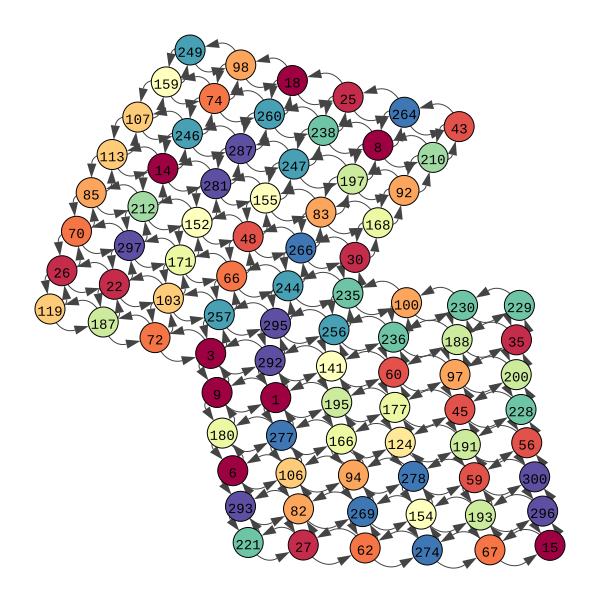

In [ ]:
graph = plot_graph(chmm, x, a, output_file="figures/stitched_rooms.pdf", multiple_episodes=True)
graph


In [ ]:
mess_fwd = get_mess_fwd(chmm, x, pseudocount_E=0.1)

In [ ]:
clone = 229
rc = np.vstack(((0, 8), rc1, (0, 8), rc2 + (5, 3)))
pf = place_field(mess_fwd, rc, clone)
pf[0, 8] = 0.0
plt.matshow(pf)
plt.savefig("figures/stitched_rooms_place_field.pdf")

## Three pentagonal cliques

Average number of clones: 5.0


  8%|▊         | 83/1000 [00:17<03:10,  4.82it/s, train_bps=2.05]


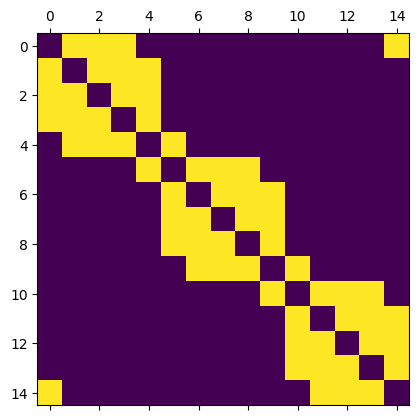

In [ ]:
T = np.zeros((15, 15))
# Connect cliques
for i in range(0, 4 + 1):
    for j in range(0, 4 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(5, 9 + 1):
    for j in range(5, 9 + 1):
        if i != j:
            T[i, j] = 1.0
for i in range(10, 14 + 1):
    for j in range(10, 14 + 1):
        if i != j:
            T[i, j] = 1.0
# Disconnect in clique connector nodes
T[0, 4] = 0.0
T[4, 0] = 0.0
T[5, 9] = 0.0
T[9, 5] = 0.0
T[10, 14] = 0.0
T[14, 10] = 0.0
# Connect cross clique connector nodes
T[4, 5] = 1.0
T[5, 4] = 1.0
T[9, 10] = 1.0
T[10, 9] = 1.0
T[14, 0] = 1.0
T[0, 14] = 1.0
plt.matshow(T)

# Draw data
states = [0]
for _ in range(10000):
    prev_state = states[-1]

    possible_next_states = np.where(T[prev_state, :])[0]
    next_state = np.random.choice(possible_next_states)
    states.append(next_state)
states = np.array(states)

state_to_obs = (
    np.array([1, 2, 3, 4, 5, 6, 1, 4, 5, 2, 8, 2, 3, 5, 7], dtype=int) - 1
)  # Aliasing version

# Create observation data
x = state_to_obs[states]
a = np.zeros(len(x), dtype=int)

n_clones = np.ones(8, dtype=np.int64) * 5
chmm = CHMM(n_clones=n_clones, pseudocount=1.0, x=x, a=a)  # Initialize the model
progression = chmm.learn_em_T(x, a, n_iter=1000)  # Training


In [ ]:
# refine learning
chmm.pseudocount = 0.0
chmm.learn_viterbi_T(x, a, n_iter=100)
states = chmm.decode(x, a)[1]
n_states = len(np.unique(states))
n_states


  3%|▎         | 3/100 [00:03<01:54,  1.18s/it, train_bps=1.99]


15

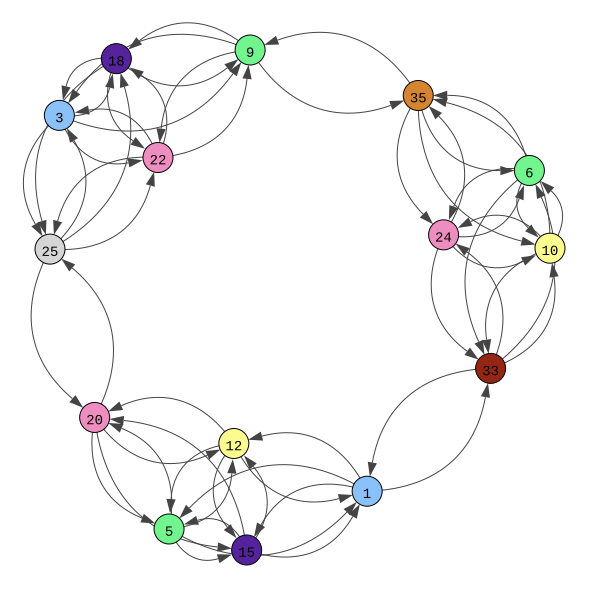

In [ ]:
cmap = colors.ListedColormap(custom_colors[[7, 3, 2, 1, 5, 0, 4, 6]])
graph = plot_graph(chmm, x, a, output_file="figures/pentagonal_cliques.pdf", cmap=cmap)
graph


- allow for one step movements only.

